$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 5: Control a Marble with Reinforcement Learning

Zach Goodenow <br>
4/23/18 <br>
CS 445 <br>

## Overview

In this assignment, I used a neural network to learn how to control a marble on a 2D surface.  I used reinforcement learning to teach the network and epsilon decay to control the exploration when learning.  I modified the reinforcement learning code used to solve the dynamic marble problem from lecture notes.  This problem is more complex because the goal position is specified as a new state variable, rather than the middle of the surface.
<br><br>
I started with code in the notebook for lecture notes 24, and the associated neural network and mlutilities from assignment 4.  They can also be downloaded in [this tar file](http://www.cs.colostate.edu/~anderson/cs445/notebooks/A5.tar).


## Requirements

<div class="alert alert-block alert-info">
* Modify the code from Lecture Notes 24 to change the
reinforcement learning problem to one for which the goal position of
the marble can be varied. In other words, your new code must train one Q network for the marble problem with a variable goal. 

* Use the plotting code from Lecture 24 to show your results.  In addition to those plots, create nine additional versions of the lower-right plot for goal positions at 1, 2, 3, 4, 5, 6, 7, 8, and 9.

The general approach is as follows.

* The state of the marble is given by $(x_t,
\dot{x_t})$.  In this new problem, the state will be $(x_t,
\dot{x_t}, g_t)$, where $g_t$ is the goal at time $t$.  Modify the
`initialState` function to randomly choose a new goal $g_t$ to be a
random value between 1 and 9. Modify `nextState` so that the goal
value remains the same in the new state as it was in the old state.  You will also
have to parameterize the reinforcement function to depend on the
current $g_t$ value.

Many of the figures will still make sense.  Include them in your
report.  The contour (and surface)
plots and the plot that tests the marble's behavior for various intial
positions must be produced for a single value of the goal.  
- Generate
several versions of the contour and surface plots and the test plots for goals of 1, 5, and 9 to show how
they vary when the goal is varied.

- Experiment with values of the parameters, such as the number of trials, number of
steps per trial, number of SCG iterations in each train call, number of hidden units, finalEpsilon, and gamma.  
- Try
to find values that result in a trained network that controls the
marble well for most of the goal settings.
Discuss your experience with finding good parameter values.

- Discuss the changes you tried and the results.

**FUNCTIONS FROM LEC 24**

I defined the ```reinforcement```, ```initialState```, and ```nextState``` functions to specify dynamic marble problem as in lecture notes 24.  I made the following changes to the functions: 
* Modify the `initialState` function to randomly choose a new goal $g_t$ to be a random value between 1 and 9. 
* Modify `nextState` so that the goal value remains the same in the new state as it was in the old state.  
* Parameterize `reinforcement` to depend on the current $g_t$ value.

I thought it might come in handy to control the values of `initialState` so I also added arguments to specify position *p*, velocity *v*, and goal position *g*.  These arguments have default values so that the function behaves the same if no arguments are passed.  

This is helpful because you can specify individual arguments but leave others the same.  For example, `initialState(g = 9)` returns a random start position, 0.0 velocity, but a goal position of 9.  Similarly, `initalState(p = 9)` returns a start position of 9, 0.0 velocity, and a random goal position between 1-9.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import neuralnetworksA4 as nn

In [4]:
from copy import copy

actions = (-1, 0, 1)   # Possible actions

def initialState(p = None, v = None, g = None):
    if not p: p = 10*np.random.random_sample()
    if not v: v = 0.0
    if not g: g = np.random.choice(range(1,10))
    return np.array([p, v, g])

# s represents the state: s[0] is position, s[1] is velocity, s[2] is goal state. 
# a is -1, 0 or 1 (move left, stay, move right)
def nextState(s,a):
    s = copy(s)   
    deltaT = 0.1                           # Euler integration time step
    s[0] += deltaT * s[1]                  # Update position
    s[1] += deltaT * (2 * a - 0.2 * s[1])  # Update velocity. Includes friction
    if s[0] < 0:        # Bound next position. If at limits, set velocity to 0.
        s = [0,0,s[2]]
    elif s[0] > 10:
        s = [10,0,s[2]]
    return s

def reinforcement(s,s1):
    goal = s[2] # Get goal state from s
    # return 0 if abs(s1[0]-goal) < 1 else -1
    return -abs(s1[0] - goal)

In [70]:
initialState()

array([ 8.78973017,  0.        ,  8.        ])

In [101]:
initialState(g = 9)

array([ 0.94949165,  0.        ,  9.        ])

In [102]:
initialState(p = 9, v = .05)

array([ 9.  ,  0.05,  2.  ])

In [104]:
s = initialState()
s

array([ 8.93060136,  0.        ,  4.        ])

In [105]:
s1 = nextState(s, -1)
s1

array([ 8.93060136, -0.2       ,  4.        ])

In [107]:
reinforcement(s,s1)

-4.9306013641316504

**Define ```epsilonGreedy``` function from lecture notes 24.**

This function controls the "exploring rate" of the network as it learns.  Epsilon values indicate the probability of choosing a random move rather than the action with the highest Q value.  It returns the action and Q

In [5]:
def epsilonGreedy(nnetQ, state, actions, epsilon):
    if np.random.uniform() < epsilon:
        # Random Move
        action = np.random.choice(actions)
    else:
        # Greedy Move
        Qs = [nnetQ.use(np.hstack((state,a)).reshape((1, -1))) for a in actions]
        ai = np.argmax(Qs)
        action = actions[ai]
    Q = nnetQ.use(np.hstack((state,action)).reshape((1, -1)))
    return action, Q

**Define ```setupStandardization``` function from lecture notes 24.**  

Used to set the standardization values of the network.

In [6]:
def setupStandardization(net, Xmeans, Xstds, Tmeans, Tstds):
    net.Xmeans = Xmeans
    net.XstdsFixed = Xstds
    net.Xconstant = [False] * len(Xmeans)
    net.TstdsFixed = net.Tstds = Tstds
    net.Tmeans = Tmeans
    net.Tconstant = [False] * len(Tstds)

**Define ```makeSamples``` function from lecture notes 24.** 

Function is still general but allows our state variable to contain multiple values.

The function takes in:
- a network - `nnet`
- initial state function - `initialStateF`
- next state function - `nextStateF`
- reinforcement function - `reinforcementF`
- valid actions - `validActions`
- number of samples - `numSamples`
- epsilon - `epsilon`

The function returns **X**, **R**, & **Qn** - arrays with *numSample* amount of rows

**X**:  "What is the current state and what action did we take"
* 4 columns - `[position, velocity, goal, action]`
* Basically a sequence of states where you roll the ball back and fourth
* Each `action` is determined using the `epsilonGreedy` function

**R**:  "How desirable is this action for this state?"
* reinforcement value calculated as `-abs(currentPosition - goalP)`
* basically represents how far away the ball is from the goal position for each sample
* a value of 0 means the ball is in the exact position of the goal

**Qn**: "What is the value of the current state?"
* Q-values calculated using `epsilonGreedy`

<div class="alert alert-block alert-warning">
Every time the function is called with the `initialState` function I defined above, the goal position is randomly selected.

If I want to choose the start position or goal position I can pass `initialStateF` a lambda value using the value I want.  For example, if I want to choose 1 as the goal position, I can make a lambda value like this `lambda: initialState(g = 1)`

In [7]:
def makeSamples(nnet, initialStateF, nextStateF, reinforcementF,
                validActions, numSamples, epsilon):

    X = np.zeros((numSamples, nnet.ni))
    R = np.zeros((numSamples, 1))
    Qn = np.zeros((numSamples, 1))

    s = initialStateF()
    s = nextStateF(s, 0)        # Update state, sn from s and a
    a, _ = epsilonGreedy(nnet, s, validActions, epsilon)
    
    # print('MAKESAMPLES: \n\ts = {} \n\ta = {}'.format(s, a))
    
    # Collect data from numSamples steps
    for step in range(numSamples):
        sn = nextStateF(s, a)        # Update state, sn from s and a
        rn = reinforcementF(s, sn)   # Calculate resulting reinforcement
        an, qn = epsilonGreedy(nnet, sn, validActions, epsilon) # Forward pass for time t+1
        X[step, :] = np.hstack((s,a))
        R[step, 0] = rn
        Qn[step, 0] = qn
        # Advance one time step
        s, a = sn, an

    return (X, R, Qn)

Here is an example of how to use `makeSamples`

In [85]:
# Make network and set up standardization
nnetQ = nn.NeuralNetwork(4, 10, 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

In [86]:
X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, 1000, 1)
for a in range(len(X)):
    print('X: ', X[a, :], 'R: ',  R[a], 'Qn: ', Qn[a])

X:  [ 2.98014352  0.          2.          1.        ] R:  [-0.98014352] Qn:  [-0.03075129]
X:  [ 2.98014352  0.2         2.         -1.        ] R:  [-1.00014352] Qn:  [-0.03519391]
X:  [ 3.00014352 -0.004       2.         -1.        ] R:  [-0.99974352] Qn:  [-0.0924132]
X:  [ 2.99974352 -0.20392     2.          0.        ] R:  [-0.97935152] Qn:  [-0.09373054]
X:  [ 2.97935152 -0.1998416   2.          0.        ] R:  [-0.95936736] Qn:  [-0.09501672]
X:  [ 2.95936736 -0.19584477  2.          0.        ] R:  [-0.93978289] Qn:  [-0.04494889]
X:  [ 2.93978289 -0.19192787  2.          1.        ] R:  [-0.9205901] Qn:  [-0.03765978]
X:  [ 2.9205901   0.01191068  2.         -1.        ] R:  [-0.92178117] Qn:  [-0.04303362]
X:  [ 2.92178117 -0.18832753  2.         -1.        ] R:  [-0.90294842] Qn:  [-0.04935962]
X:  [ 2.90294842 -0.38456098  2.         -1.        ] R:  [-0.86449232] Qn:  [-0.05657289]
X:  [ 2.86449232 -0.57686976  2.         -1.        ] R:  [-0.80680534] Qn:  [-0.05616423]
X

X:  [ 6.70957647  0.65808471  2.         -1.        ] R:  [-4.77538494] Qn:  [ 0.17716276]
X:  [ 6.77538494  0.44492301  2.          0.        ] R:  [-4.81987725] Qn:  [ 0.11849114]
X:  [ 6.81987725  0.43602455  2.         -1.        ] R:  [-4.8634797] Qn:  [ 0.18608513]
X:  [ 6.8634797   0.22730406  2.          0.        ] R:  [-4.88621011] Qn:  [ 0.12121769]
X:  [ 6.88621011  0.22275798  2.         -1.        ] R:  [-4.9084859] Qn:  [ 0.12217479]
X:  [ 6.9084859   0.01830282  2.         -1.        ] R:  [-4.91031619] Qn:  [ 0.24893106]
X:  [ 6.91031619 -0.18206324  2.          1.        ] R:  [-4.89210986] Qn:  [ 0.19008186]
X:  [ 6.89210986  0.02157803  2.          0.        ] R:  [-4.89426767] Qn:  [ 0.12155655]
X:  [ 6.89426767  0.02114647  2.         -1.        ] R:  [-4.89638231] Qn:  [ 0.12151582]
X:  [ 6.89638231 -0.17927646  2.         -1.        ] R:  [-4.87845467] Qn:  [ 0.12039881]
X:  [ 6.87845467 -0.37569093  2.         -1.        ] R:  [-4.84088557] Qn:  [ 0.22859948]
X

X:  [ 7.70375226 -1.14075045  2.          0.        ] R:  [-5.58967721] Qn:  [ 0.16080341]
X:  [ 7.58967721 -1.11793544  2.         -1.        ] R:  [-5.47788367] Qn:  [ 0.23057169]
X:  [ 7.47788367 -1.29557673  2.          0.        ] R:  [-5.34832599] Qn:  [ 0.14707989]
X:  [ 7.34832599 -1.2696652   2.         -1.        ] R:  [-5.22135947] Qn:  [ 0.2045493]
X:  [ 7.22135947 -1.44427189  2.          1.        ] R:  [-5.07693228] Qn:  [ 0.20808653]
X:  [ 7.07693228 -1.21538646  2.          0.        ] R:  [-4.95539364] Qn:  [ 0.20546891]
X:  [ 6.95539364 -1.19107873  2.          1.        ] R:  [-4.83628577] Qn:  [ 0.19257618]
X:  [ 6.83628577 -0.96725715  2.          0.        ] R:  [-4.73956005] Qn:  [ 0.2070996]
X:  [ 6.73956005 -0.94791201  2.          1.        ] R:  [-4.64476885] Qn:  [ 0.21244939]
X:  [ 6.64476885 -0.72895377  2.          1.        ] R:  [-4.57187347] Qn:  [ 0.17181397]
X:  [ 6.57187347 -0.51437469  2.          0.        ] R:  [-4.520436] Qn:  [ 0.16807958]
X: 

X:  [ 0.08783006 -0.41756601  2.         -1.        ] R:  [-1.95392655] Qn:  [-0.14630651]
X:  [ 0.04607345 -0.60921469  2.         -1.        ] R:  [-2.] Qn:  [-0.29445295]
X:  [ 0.  0.  2.  1.] R:  [-2.] Qn:  [-0.1305034]
X:  [ 0.   0.2  2.  -1. ] R:  [-1.98] Qn:  [-0.29312504]
X:  [ 0.02  -0.004  2.     1.   ] R:  [-1.9804] Qn:  [-0.2977648]
X:  [ 0.0196   0.19608  2.       1.     ] R:  [-1.960792] Qn:  [-0.12619263]
X:  [ 0.039208   0.3921584  2.        -1.       ] R:  [-1.92157616] Qn:  [-0.29381203]
X:  [ 0.07842384  0.18431523  2.          1.        ] R:  [-1.90314464] Qn:  [-0.12461929]
X:  [ 0.09685536  0.38062893  2.         -1.        ] R:  [-1.86508174] Qn:  [-0.22706511]
X:  [ 0.13491826  0.17301635  2.          0.        ] R:  [-1.84778011] Qn:  [-0.288747]
X:  [ 0.15221989  0.16955602  2.          1.        ] R:  [-1.83082451] Qn:  [-0.22702177]
X:  [ 0.16917549  0.3661649   2.          0.        ] R:  [-1.79420802] Qn:  [-0.22587029]
X:  [ 0.20579198  0.3588416   2.    

X:  [ 6.65183416  0.46963317  2.          0.        ] R:  [-4.69879747] Qn:  [ 0.17117816]
X:  [ 6.69879747  0.46024051  2.          0.        ] R:  [-4.74482152] Qn:  [ 0.26716807]
X:  [ 6.74482152  0.4510357   2.          1.        ] R:  [-4.78992509] Qn:  [ 0.17587512]
X:  [ 6.78992509  0.64201498  2.          0.        ] R:  [-4.85412659] Qn:  [ 0.27978582]
X:  [ 6.85412659  0.62917468  2.          1.        ] R:  [-4.91704406] Qn:  [ 0.29010449]
X:  [ 6.91704406  0.81659119  2.          1.        ] R:  [-4.99870318] Qn:  [ 0.12306835]
X:  [ 6.99870318  1.00025936  2.         -1.        ] R:  [-5.09872912] Qn:  [ 0.19756085]
X:  [ 7.09872912  0.78025418  2.          0.        ] R:  [-5.17675453] Qn:  [ 0.13045393]
X:  [ 7.17675453  0.76464909  2.         -1.        ] R:  [-5.25321944] Qn:  [ 0.13455765]
X:  [ 7.25321944  0.54935611  2.         -1.        ] R:  [-5.30815505] Qn:  [ 0.28956084]
X:  [ 7.30815505  0.33836899  2.          1.        ] R:  [-5.34199195] Qn:  [ 0.13802274]

X:  [ 8.6213945  0.0757211  2.        -1.       ] R:  [-6.62896661] Qn:  [ 0.2018901]
X:  [ 8.62896661 -0.12579332  2.         -1.        ] R:  [-6.61638728] Qn:  [ 0.30088923]
X:  [ 8.61638728 -0.32327746  2.          1.        ] R:  [-6.58405953] Qn:  [ 0.29436974]
X:  [ 8.58405953 -0.11681191  2.          0.        ] R:  [-6.57237834] Qn:  [ 0.31022563]
X:  [ 8.57237834 -0.11447567  2.          1.        ] R:  [-6.56093077] Qn:  [ 0.19446501]
X:  [ 8.56093077  0.08781385  2.         -1.        ] R:  [-6.56971216] Qn:  [ 0.19889077]
X:  [ 8.56971216 -0.11394243  2.         -1.        ] R:  [-6.55831791] Qn:  [ 0.29152753]
X:  [ 8.55831791 -0.31166358  2.          0.        ] R:  [-6.52715156] Qn:  [ 0.29959873]
X:  [ 8.52715156 -0.30543031  2.          1.        ] R:  [-6.49660852] Qn:  [ 0.30907492]
X:  [ 8.49660852 -0.0993217   2.          1.        ] R:  [-6.48667635] Qn:  [ 0.19087617]
X:  [ 8.48667635  0.10266473  2.         -1.        ] R:  [-6.49694283] Qn:  [ 0.19522397]
X:  

X:  [ 0.  0.  2.  1.] R:  [-2.] Qn:  [-0.1305034]
X:  [ 0.   0.2  2.  -1. ] R:  [-1.98] Qn:  [-0.13362511]
X:  [ 0.02  -0.004  2.    -1.   ] R:  [-1.9804] Qn:  [-0.22908165]
X:  [ 0.0196  -0.20392  2.       0.     ] R:  [-2.] Qn:  [-0.13413268]
X:  [ 0.  0.  2. -1.] R:  [-2.] Qn:  [-0.22969146]
X:  [ 0.  -0.2  2.   0. ] R:  [-2.] Qn:  [-0.13413268]
X:  [ 0.  0.  2. -1.] R:  [-2.] Qn:  [-0.28937045]
X:  [ 0.  -0.2  2.   1. ] R:  [-2.] Qn:  [-0.13413268]
X:  [ 0.  0.  2. -1.] R:  [-2.] Qn:  [-0.28937045]
X:  [ 0.  -0.2  2.   1. ] R:  [-2.] Qn:  [-0.29445295]
X:  [ 0.  0.  2.  1.] R:  [-2.] Qn:  [-0.1305034]
X:  [ 0.   0.2  2.  -1. ] R:  [-1.98] Qn:  [-0.29312504]
X:  [ 0.02  -0.004  2.     1.   ] R:  [-1.9804] Qn:  [-0.2977648]
X:  [ 0.0196   0.19608  2.       1.     ] R:  [-1.960792] Qn:  [-0.30059555]
X:  [ 0.039208   0.3921584  2.         1.       ] R:  [-1.92157616] Qn:  [-0.12219012]
X:  [ 0.07842384  0.58431523  2.         -1.        ] R:  [-1.86314464] Qn:  [-0.12352368]
X:  [ 0.1

X:  [ 1.50526737 -0.30105347  2.          0.        ] R:  [-0.52483797] Qn:  [-0.09538286]
X:  [ 1.47516203 -0.29503241  2.         -1.        ] R:  [-0.55434121] Qn:  [-0.17298306]
X:  [ 1.44565879 -0.48913176  2.          0.        ] R:  [-0.60325439] Qn:  [-0.18038568]
X:  [ 1.39674561 -0.47934912  2.          1.        ] R:  [-0.6511893] Qn:  [-0.18861213]
X:  [ 1.3488107  -0.26976214  2.          1.        ] R:  [-0.67816552] Qn:  [-0.18209949]
X:  [ 1.32183448 -0.0643669   2.          0.        ] R:  [-0.68460221] Qn:  [-0.18238728]
X:  [ 1.31539779 -0.06307956  2.          0.        ] R:  [-0.69091016] Qn:  [-0.19596066]
X:  [ 1.30908984 -0.06181797  2.          1.        ] R:  [-0.69709196] Qn:  [-0.0905978]
X:  [ 1.30290804  0.13941839  2.         -1.        ] R:  [-0.68315012] Qn:  [-0.1823224]
X:  [ 1.31684988 -0.06336998  2.          0.        ] R:  [-0.68948712] Qn:  [-0.09489826]
X:  [ 1.31051288 -0.06210258  2.         -1.        ] R:  [-0.69569737] Qn:  [-0.19252056]
X:

Here is an example of how to specify starting position and goal position using lambda

In [87]:
X, R, Qn = makeSamples(nnetQ, lambda: initialState(p = 9, g = 1), nextState, reinforcement, actions, 1000, 1)
for a in range(len(X)):
    print('X: ', X[a, :], 'R: ',  R[a], 'Qn: ', Qn[a])

X:  [ 9.  0.  1. -1.] R:  [-8.] Qn:  [ 0.3558666]
X:  [ 9.  -0.2  1.   1. ] R:  [-7.98] Qn:  [ 0.36635615]
X:  [  8.98000000e+00   4.00000000e-03   1.00000000e+00   1.00000000e+00] R:  [-7.9804] Qn:  [ 0.19989815]
X:  [ 8.9804   0.20392  1.      -1.     ] R:  [-8.000792] Qn:  [ 0.20555229]
X:  [  9.00079200e+00  -1.58400000e-04   1.00000000e+00  -1.00000000e+00] R:  [-8.00077616] Qn:  [ 0.35587554]
X:  [ 9.00077616 -0.20015523  1.          1.        ] R:  [-7.98076064] Qn:  [ 0.20464295]
X:  [  8.98076064e+00   3.84787264e-03   1.00000000e+00  -1.00000000e+00] R:  [-7.98114542] Qn:  [ 0.3556473]
X:  [ 8.98114542 -0.19622908  1.          1.        ] R:  [-7.96152252] Qn:  [ 0.2037717]
X:  [  8.96152252e+00   7.69549688e-03   1.00000000e+00  -1.00000000e+00] R:  [-7.96229207] Qn:  [ 0.35542361]
X:  [ 8.96229207 -0.19245841  1.          1.        ] R:  [-7.94304622] Qn:  [ 0.20293687]
X:  [ 8.94304622  0.01139076  1.         -1.        ] R:  [-7.9441853] Qn:  [ 0.32101174]
X:  [ 8.9441853

X:  [ 8.38259325 -0.47651865  1.         -1.        ] R:  [-7.33494138] Qn:  [ 0.18960757]
X:  [ 8.33494138 -0.66698828  1.         -1.        ] R:  [-7.26824255] Qn:  [ 0.30186474]
X:  [ 8.26824255 -0.85364851  1.          1.        ] R:  [-7.1828777] Qn:  [ 0.27672728]
X:  [ 8.1828777  -0.63657554  1.          0.        ] R:  [-7.11922015] Qn:  [ 0.30963781]
X:  [ 8.11922015 -0.62384403  1.          1.        ] R:  [-7.05683575] Qn:  [ 0.26960673]
X:  [ 8.05683575 -0.41136715  1.          0.        ] R:  [-7.01569903] Qn:  [ 0.17151516]
X:  [ 8.01569903 -0.40313981  1.         -1.        ] R:  [-6.97538505] Qn:  [ 0.30650437]
X:  [ 7.97538505 -0.59507701  1.          1.        ] R:  [-6.91587735] Qn:  [ 0.26077932]
X:  [ 7.91587735 -0.38317547  1.          0.        ] R:  [-6.8775598] Qn:  [ 0.25832632]
X:  [ 7.8775598  -0.37551196  1.          0.        ] R:  [-6.84000861] Qn:  [ 0.31348202]
X:  [ 7.84000861 -0.36800172  1.          1.        ] R:  [-6.80320843] Qn:  [ 0.2528364]
X:

X:  [ 6.62817262 -0.12563452  1.          1.        ] R:  [-5.61560917] Qn:  [ 0.11382191]
X:  [ 6.61560917  0.07687817  1.         -1.        ] R:  [-5.62329699] Qn:  [ 0.26904491]
X:  [ 6.62329699 -0.1246594   1.          1.        ] R:  [-5.61083105] Qn:  [ 0.16469839]
X:  [ 6.61083105  0.07783379  1.          0.        ] R:  [-5.61861443] Qn:  [ 0.276558]
X:  [ 6.61861443  0.07627711  1.          1.        ] R:  [-5.62624214] Qn:  [ 0.11445599]
X:  [ 6.62624214  0.27475157  1.         -1.        ] R:  [-5.6537173] Qn:  [ 0.27831728]
X:  [ 6.6537173   0.06925654  1.          1.        ] R:  [-5.66064295] Qn:  [ 0.28599534]
X:  [ 6.66064295  0.26787141  1.          1.        ] R:  [-5.68743009] Qn:  [ 0.29423126]
X:  [ 6.68743009  0.46251398  1.          1.        ] R:  [-5.73368149] Qn:  [ 0.30308102]
X:  [ 6.73368149  0.6532637   1.          1.        ] R:  [-5.79900786] Qn:  [ 0.16864552]
X:  [ 6.79900786  0.84019843  1.          0.        ] R:  [-5.8830277] Qn:  [ 0.12115543]
X: 

X:  [ 0.078408   0.1843184  1.        -1.       ] R:  [-0.90316016] Qn:  [-0.10491441]
X:  [ 0.09683984 -0.01936797  1.         -1.        ] R:  [-0.90509696] Qn:  [-0.20122877]
X:  [ 0.09490304 -0.21898061  1.          0.        ] R:  [-0.92699502] Qn:  [-0.10756941]
X:  [ 0.07300498 -0.214601    1.         -1.        ] R:  [-0.94845512] Qn:  [-0.27773603]
X:  [ 0.05154488 -0.41030898  1.          1.        ] R:  [-0.98948601] Qn:  [-0.10920864]
X:  [ 0.01051399 -0.2021028   1.         -1.        ] R:  [-1.] Qn:  [-0.29070993]
X:  [ 0.  0.  1.  1.] R:  [-1.] Qn:  [-0.29481966]
X:  [ 0.   0.2  1.   1. ] R:  [-0.98] Qn:  [-0.20916746]
X:  [ 0.02   0.396  1.     0.   ] R:  [-0.9404] Qn:  [-0.20790084]
X:  [ 0.0596   0.38808  1.       0.     ] R:  [-0.901592] Qn:  [-0.20664885]
X:  [ 0.098408   0.3803184  1.         0.       ] R:  [-0.86356016] Qn:  [-0.28944373]
X:  [ 0.13643984  0.37271203  1.          1.        ] R:  [-0.82628896] Qn:  [-0.29010723]
X:  [ 0.17371104  0.56525779  1.    

X:  [ 4.07729908  1.38454018  1.          0.        ] R:  [-3.2157531] Qn:  [ 0.04338399]
X:  [ 4.2157531   1.35684938  1.         -1.        ] R:  [-3.35143803] Qn:  [-0.01214826]
X:  [ 4.35143803  1.12971239  1.          0.        ] R:  [-3.46440927] Qn:  [ 0.11959461]
X:  [ 4.46440927  1.10711815  1.          1.        ] R:  [-3.57512109] Qn:  [ 0.130807]
X:  [ 4.57512109  1.28497578  1.          1.        ] R:  [-3.70361867] Qn:  [ 0.14359796]
X:  [ 4.70361867  1.45927627  1.          1.        ] R:  [-3.84954629] Qn:  [ 0.06318531]
X:  [ 4.84954629  1.63009074  1.         -1.        ] R:  [-4.01255537] Qn:  [ 0.06774215]
X:  [ 5.01255537  1.39748893  1.         -1.        ] R:  [-4.15230426] Qn:  [ 0.04145396]
X:  [ 5.15230426  1.16953915  1.          0.        ] R:  [-4.26925817] Qn:  [ 0.04997372]
X:  [ 5.26925817  1.14614837  1.          0.        ] R:  [-4.38387301] Qn:  [ 0.05842281]
X:  [ 5.38387301  1.1232254   1.          0.        ] R:  [-4.49619555] Qn:  [ 0.21881726]
X:

X:  [ 5.66916111 -0.53383222  1.         -1.        ] R:  [-4.61577788] Qn:  [ 0.10027469]
X:  [ 5.61577788 -0.72315558  1.          0.        ] R:  [-4.54346233] Qn:  [ 0.09471792]
X:  [ 5.54346233 -0.70869247  1.          0.        ] R:  [-4.47259308] Qn:  [ 0.08927659]
X:  [ 5.47259308 -0.69451862  1.          0.        ] R:  [-4.40314122] Qn:  [ 0.17149588]
X:  [ 5.40314122 -0.68062824  1.          1.        ] R:  [-4.33507839] Qn:  [ 0.17342775]
X:  [ 5.33507839 -0.46701568  1.          1.        ] R:  [-4.28837683] Qn:  [ 0.06950245]
X:  [ 5.28837683 -0.25767537  1.          0.        ] R:  [-4.26260929] Qn:  [ 0.06080968]
X:  [ 5.26260929 -0.25252186  1.         -1.        ] R:  [-4.2373571] Qn:  [ 0.16678581]
X:  [ 5.2373571  -0.44747142  1.          1.        ] R:  [-4.19260996] Qn:  [ 0.05843108]
X:  [ 5.19260996 -0.23852199  1.         -1.        ] R:  [-4.16875776] Qn:  [ 0.06320266]
X:  [ 5.16875776 -0.43375155  1.          0.        ] R:  [-4.12538261] Qn:  [ 0.05265677]


## Testing functions

Define a function to "plop" the marble down at a number of positions and try to control it, plotting the results.  I based the function off `testIt` from lecture 24 notes.  I changed the function to plot the dashed line for the goal position and made it thinner to see the trials more easily.

The function takes in:
- a trained network - `Qnet`
- number of trails to try - `nTrials`
    - determines starting position
    - function will automatically pick starting positions evenly spaced between 0 and 10
    
    
- number of actions per trial - `nStepsPerTrial`
- goal position for marble - `goalP` -- default is 5
- `groupPlot` boolean defaults to true for when the plot is the last subplot for trials and `plotStatus` use

The function `testAll` uses the network to test behavior at all goal positions.  Calling `testIt` for every starting position.  Each goal position is marked with a vertical dashed line.  

In [56]:
def testIt(Qnet, nTrials, nStepsPerTrial, goalP = 5, groupPlot = True):
    xs = np.linspace(0,10,nTrials) # evenly distribute start position for each trial
    if(groupPlot): plt.subplot(4,3,12)
    for x in xs:
        # GOING TO HAVE TO CHANGE SOMETHING HERE SINCE S NOW HAS A 3RD ELEMENT -- GOAL POSITION
        # s = [x,0] ## 0 velocity
        s = [x,0,goalP] ## 0 velocity, goal specified
        xtrace = np.zeros((nStepsPerTrial,2))
        # xtrace = np.zeros((nStepsPerTrial,3))
        for step in range(nStepsPerTrial):
            a,_ = epsilonGreedy(Qnet,s,actions,0.0) # epsilon = 0 because we dont want random action
            s = nextState(s,a)
            xtrace[step,:] = s[:2]
        plt.plot(xtrace[:,0],xtrace[:,1])
        plt.xlim(-1,11)
        plt.ylim(-5,5)
        plt.plot([goalP,goalP],[-5,5],'--',alpha=0.5,lw=2)
        # plt.ylabel('$\dot{x}$')
        plt.ylabel('Velocity')
        # plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$')
        
def testAll(Qnet, nTrials, nStepsPerTrial, groupPlot = False):
    for goal in range(1,10):
        plt.subplot(3,3,goal)
        testIt(Qnet, nTrials, nStepsPerTrial, goal, groupPlot)

##### Usage and examples

In [14]:
# make network
nnetQ = nn.NeuralNetwork(4, 10, 1)  # ((0,10),(-4,4),(-1,1)))
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

# vars
gamma = 0.8        # discount factor
nTrials = 100         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 500 # number of steps between new random initial states
nSCGIterations = 4  # maximum number of SCG iterations
finalEpsilon = 0.01 # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon)/(nTrials)) # to produce this final value

epsilon = 1         # initial epsilon value
for trial in range(nTrials):
    # Train the network
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    nnetQ.train(X, R + gamma*Qn, nIterations=nSCGIterations)
    
    # Update epsilon
    epsilon *= epsilonDecay
    
    if(trial % 50 == 0): print('trial ', trial)

trial  0
trial  50


In this example you can see that each trial is gradually moving towards the goal state of 7 and eventually stays in that area with a low velocity.  This is what these plots should look like if the network has learned how to move to the goal position correctly.

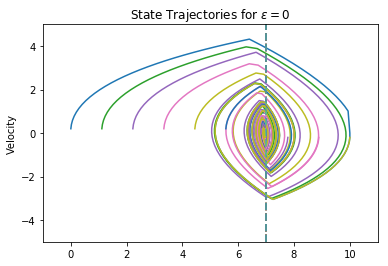

In [17]:
testIt(nnetQ, 10, 500, 7, False)

Unfortunately, the network is not accurate for all goal states.  This might indicate that the network needs to be trained longer or learn less quickly.  I will go on to attempt to improve the accuracy of the network by changing input options later.

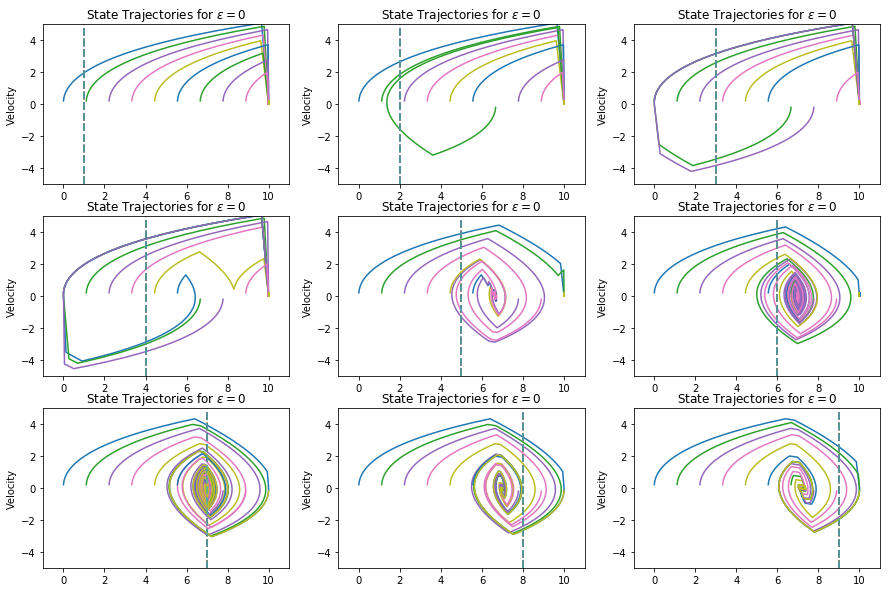

In [19]:
fig = plt.figure(figsize=(15,10))
testAll(nnetQ, 10, 500)

Different try with more trials and more steps per trial

In [21]:
# make network
nnetQ = nn.NeuralNetwork(4, 10, 1)  # ((0,10),(-4,4),(-1,1)))
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

# vars
gamma = 0.8        # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4  # maximum number of SCG iterations
finalEpsilon = 0.01 # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon)/(nTrials)) # to produce this final value


epsilon = 1         # initial epsilon value
for trial in range(nTrials):
    # Train the network
    X, R, Qn = makeSamples(nnetQ,  initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    nnetQ.train(X, R + gamma*Qn, nIterations=nSCGIterations)
    
    # Update epsilon
    epsilon *= epsilonDecay
    
    if(trial % 50 == 0): print('trial ', trial)

trial  0
trial  50
trial  100
trial  150
trial  200
trial  250
trial  300
trial  350
trial  400
trial  450


This one is doing pretty good for most of the goal positions because you can see that the trials are ending on the dotted line.  It isn't doing very good for 1 because the ending positions are higher than they should be.  It looks like it is favoring the more right action.  

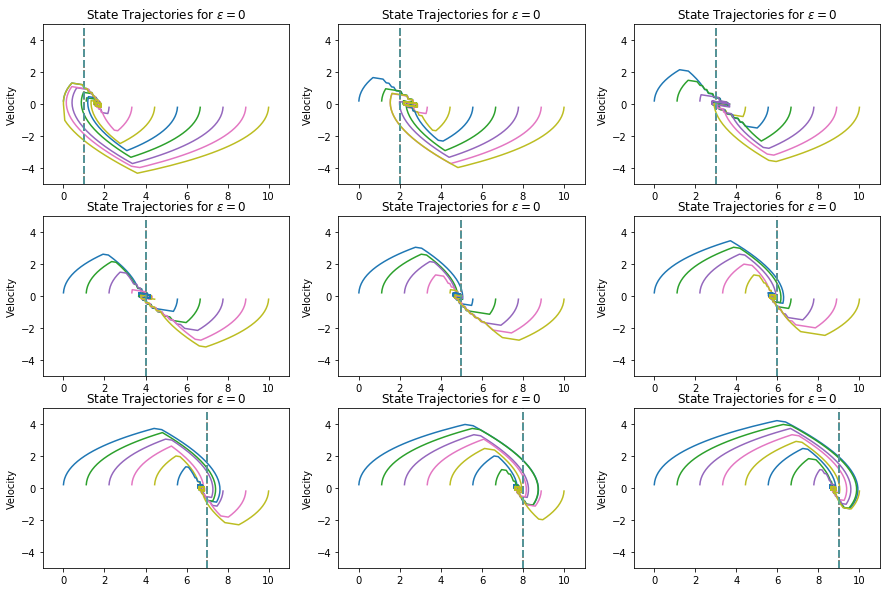

In [25]:
fig = plt.figure(figsize=(15,10))
testAll(nnetQ, 10, 500)

### Test starting direction plot function

I wanted to make a more simple way of judging if a network was accurate or not.  The following function tests a network's starting action decision for all combinations of current position and goal position where velocity is 0.  I represent the correct direction as a 10x8 numpy array where the rows represent current position (0-10) and the columns represent goal position (1-9).  If the ball is to the left of the goal position, the action should be move right (1).  If the ball is to the right of the goal position, the action should be move left (-1).  If the ball is currently in the goal position, the action should be stay there (0).

I then compare the values for each (current, goal) combination for the network.  If the arrow is yellow, the network was correct, if the arrow is purple, the network was incorrect.

After I made this plot I realized that this information is pretty much already displayed in the plots from `plotStatus` but I really like how it turned out.  It also helped me get a better understanding of how to work with the network to produce data I can use to evaluate the network.  Also it helped me get more comfortable with plotting in python with matplotlib.

In [57]:
def testStarts(Qnet, makeSub = False): #, fromPlotStatus = False
    if(makeSub): plt.subplot(4,3,9)
    X, Y = np.meshgrid(np.array(range(11)), np.array(range(11)))
    correctArrow = np.zeros((11,11)) # correct action to take
    V = np.zeros((11,11))
    networkGuess = np.zeros((11,11)) # predictions from the network
    for ex in range(11):
        for why in range(11):
            if X[ex, why] < Y[ex, why]: correctArrow[ex, why] = -1 # move left
            if X[ex, why] > Y[ex, why]: correctArrow[ex, why] = 1 # move right
            #networkGuess[why, ex],_ = epsilonGreedy(Qnet,[ex, 0.0, why],actions,0.0)
            networkGuess[ex, why],_ = epsilonGreedy(Qnet,[ex, 0.0, why],actions,0.0)

    # get arrow colors
    colorOfArrow = np.array(networkGuess == correctArrow).astype(int)
            
    #plt.figure()
    for xc in range(11): plt.axvline(x=xc,alpha=0.5,lw=1,color='black')
    plt.quiver(X, Y, networkGuess, V, colorOfArrow)
    plt.title('Start Direction')
    plt.xlabel("Goal position")
    plt.ylabel("Ball position")
    #plt.xlim(1,9)
    #plt.grid()

##### Usage and examples

The following plot is a visual of what the ideal network would produce.  I actually use this array to compare to the array that the network produces and determine the color.

In [49]:
X, Y = np.meshgrid(np.array(range(11)), np.array(range(11)))
correctArrow = np.zeros((11,11))
V = np.zeros((11,11))
for ex in range(11):
    for why in range(11):
        if X[ex, why] < Y[ex, why]: correctArrow[ex, why] = -1 # move left
        if X[ex, why] > Y[ex, why]: correctArrow[ex, why] = 1 # move right

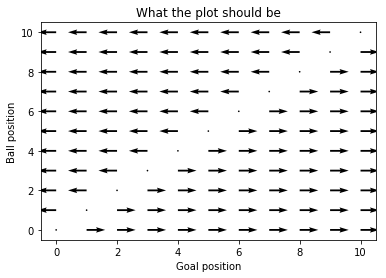

In [51]:
plt.figure()
plt.title('What the plot should be')
plt.xlabel("Goal position")
plt.ylabel("Ball position")
Q = plt.quiver(X, Y, correctArrow, V)

Here I can tell that the network is doing quite well when velocity is 0 because there are mostly yellow arrows on the plot. Arrows that are yellow indicate that the network made the correct action move towards the goal while purple arrows indicate a wrong action move.  It is interesting that purple arrows are all in positions where the ball is in the goal position.  This means that the action should be `0` or stay, but the network is moving the ball inwards for those that it got wrong.  

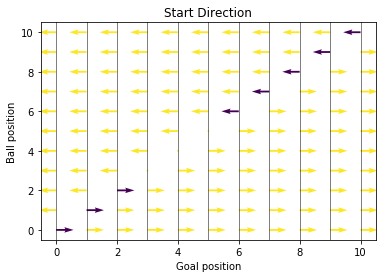

In [36]:
testStarts(nnetQ)

### Plot Status function

**Define a *plotStatus* function to show how the network is doing.**<br>
This function was taken from lecture notes 24. I modified the arguments to take in the goal position of the network for the most recent data set. I made the following changes to the plots made by `plotStatus`:
- **Subplot 2**: <br>
1.) Red title with goal position and trial number  
2.) Horizontal line is plotted for goal position and thinned. <br>
3.) Pass goal position as an argument when using the network <br>
- **Subplot 5**: <br>
1.) Red shade moved to be between goal position +- 1
- **Subplot 7**: <br>
1.) Pass goal position to network when using
- **Subplot 9**: <br>
1.) Insert my start direction arrow plot in this empty space to give more information about status
- **Subplot 10 & 11**: <br>
1.) Removed 2D X and Y axis because they were overlapping with the 3D plot. Makes plot look cleaner and easier to read

In [71]:
# THIS IS THE EXAMPLE TO START
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def plotStatus(net,trial,epsilonTrace,rtrace,goalP=5):
    plt.subplot(4,3,1)
    plt.plot(epsilonTrace[:trial+1])
    plt.ylabel("Random Action Probability ($\epsilon$)")
    plt.ylim(0,1)
    
    plt.subplot(4,3,2)
    plt.title('GOAL: ' + str(int(goalP)) + '  TRIAL #: ' + str(trial), fontsize = 10, color = 'red')
    plt.plot(X[:,0])
    plt.plot([0,X.shape[0]], [goalP,goalP],'--',alpha=0.5,lw=2)
    plt.ylabel("$x$")
    plt.ylim(-1,11)
    #qs = [[net.use([s,0,a]) for a in actions] for s in range(11)]
    # HAD TO PUT IN THE GOAL STATE HERE.  PUT 5 JUST FOR Ss AND Gs. MIGHT HAVE TO CHANGE LATER....
    # qs = net.use(np.array([[s,0,a] for a in actions for s in range(11)]))
    qs = net.use(np.array([[s,0,goalP,a] for a in actions for s in range(11)]))
    #print np.hstack((qs,-1+np.argmax(qs,axis=1).reshape((-1,1))))
    
    plt.subplot(4,3,3)
    acts = ["L","0","R"]
    actsiByState = np.argmax(qs.reshape((len(actions),-1)),axis=0)
    for i in range(11):
        plt.text(i,0,acts[actsiByState[i]])
        plt.xlim(-1,11)
        plt.ylim(-1,1)
    plt.text(2,0.2,"Policy for Zero Velocity")
    plt.axis("off")
    
    plt.subplot(4,3,4)
    plt.plot(rtrace[:trial+1],alpha=0.5)
    #plt.plot(np.convolve(rtrace[:trial+1],np.array([0.02]*50),mode='valid'))
    binSize = 20
    if trial+1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(rtrace[:int(trial/binSize)*binSize].reshape((int(trial/binSize),binSize)),axis=1)
        plt.plot(np.arange(1,1+int(trial/binSize))*binSize,smoothed)
    plt.ylabel("Mean reinforcement")
    
    plt.subplot(4,3,5)
    plt.plot(X[:,0],X[:,1])
    plt.plot(X[0,0],X[0,1],'o')
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    #plt.fill_between([4,6],[-5,-5],[5,5],color="red",alpha=0.3)
    plt.fill_between([max(0,goalP-1),min(10,goalP+1)],[-5,-5],[5,5],color="red",alpha=0.3)
    plt.xlim(-1,11)
    plt.ylim(-5,5)
    
    plt.subplot(4,3,6)
    net.draw(["$x$","$\dot{x}$","$a$"],["Q"])
    
    plt.subplot(4,3,7)
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    #states = np.vstack((xs.flat,ys.flat)).T
    #qs = [net.use(np.hstack((states,np.ones((states.shape[0],1))*act))) for act in actions]
    xsflat = xs.flat
    ysflat = ys.flat
    qs = net.use(np.array([[xsflat[i],ysflat[i],goalP,a] for a in actions for i in range(len(xsflat))]))
    #qs = np.array(qs).squeeze().T
    qs = qs.reshape((len(actions),-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax)
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Max Q")
    
    plt.subplot(4,3,8)
    acts = np.array(actions)[np.argmax(qs,axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs,ys,acts,[-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Actions")
    
    plt.subplot(4,3,9)
    testStarts(net)
    
    s = plt.subplot(4,3,10)
    plt.axis('off')
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,qsmax,cstride=1,rstride=1,cmap=cm.jet,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Max Q")
    plt.title("Max Q")
    
    s = plt.subplot(4,3,11)
    plt.axis('off')
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,acts,cstride=1,rstride=1,cmap=cm.jet,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Action")
    plt.title("Action")
    
    plt.axis('on')
    
    plt.tight_layout()

### Contour and surface plots for goals 1, 5, and 9 helper function

Generate several versions of the contour and surface plots and the test plots for goals of 1, 5, and 9 to show how they vary when the goal is varied. I explain these plots and how I judge them later on in the example section.  I could condensed the code since a lot of the lines are used for each plot but for now I will leave it long.

In [103]:
def plotContours(net):
    # Stuff they all need
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    xsflat = xs.flat
    ysflat = ys.flat
    
    
    # Plots for 1
    plt.subplot(4,3,1)
    qs = net.use(np.array([[xsflat[i],ysflat[i],1,a] for a in actions for i in range(len(xsflat))]))
    qs = qs.reshape((len(actions),-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax)
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("Q Contour", fontsize = 14, color = 'red')
    plt.title("Goal = 1", fontsize = 14, color = 'red')
    
    plt.subplot(4,3,4)
    acts = np.array(actions)[np.argmax(qs,axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs,ys,acts,[-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("Actions Contour", fontsize = 14, color = 'red')

    s = plt.subplot(4,3,7)
    plt.axis('off')
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,qsmax,cstride=1,rstride=1,cmap=cm.jet,linewidth=0)
    ax.set_xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Max Q Surface")
    
    s = plt.subplot(4,3,10)
    plt.axis('off')
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,acts,cstride=1,rstride=1,cmap=cm.jet,linewidth=0)
    ax.set_xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Action Surface")
    plt.axis('on')
    

    
    # Plots for 5
    plt.subplot(4,3,2)
    qs = net.use(np.array([[xsflat[i],ysflat[i],5,a] for a in actions for i in range(len(xsflat))]))
    qs = qs.reshape((len(actions),-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax)
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.title("Goal = 5", fontsize = 14, color = 'red')
    
    plt.subplot(4,3,5)
    acts = np.array(actions)[np.argmax(qs,axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs,ys,acts,[-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")

    s = plt.subplot(4,3,8)
    plt.axis('off')
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,qsmax,cstride=1,rstride=1,cmap=cm.jet,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Max Q")
    plt.title("Max Q Surface")
    
    s = plt.subplot(4,3,11)
    plt.axis('off')
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,acts,cstride=1,rstride=1,cmap=cm.jet,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Action")
    plt.title("Action Surface")
    plt.axis('on')
    
    
    # Plots for 9
    plt.subplot(4,3,3)
    qs = net.use(np.array([[xsflat[i],ysflat[i],9,a] for a in actions for i in range(len(xsflat))]))
    qs = qs.reshape((len(actions),-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax)
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.title("Goal = 9", fontsize = 14, color = 'red')
    
    plt.subplot(4,3,6)
    acts = np.array(actions)[np.argmax(qs,axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs,ys,acts,[-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")

    s = plt.subplot(4,3,9)
    plt.axis('off')
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,qsmax,cstride=1,rstride=1,cmap=cm.jet,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Max Q")
    plt.title("Max Q Surface")
    
    s = plt.subplot(4,3,12)
    plt.axis('off')
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,acts,cstride=1,rstride=1,cmap=cm.jet,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Action")
    plt.title("Action Surface")
    plt.axis('on')
    
    plt.tight_layout()

## All plots for a few examples

This is a chunk of code used to plot the network from lecture 24.  I modified a few things since state now has 3 values instead of 4. I also run the 9 state trajectory plots along with the contour & surface plots for goal 1, 5, and 9.

The argument choices I made for the next few examples were influenced by my experiments with the network. I put these experiments at the bottom of the notebook to clean it up a bit.

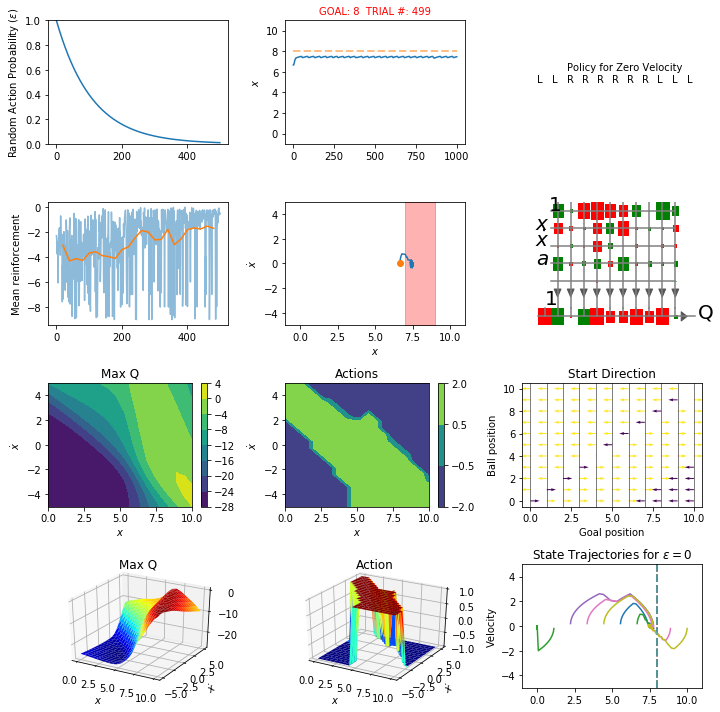

In [96]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10,10))

gamma = 0.8        # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4  # maximum number of SCG iterations
finalEpsilon = 0.01 # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon)/(nTrials)) # to produce this final value
print("epsilonDecay is",epsilonDecay)

nh = 10           # number of hidden units
# MIGHT HAVE TO CHANGE 3 TO 4 -- 4 INPUTS NOW SINCE WE HAVE GOAL POSITION NOW.......
# nnetQ = nn.NeuralNetwork(3, nh, 1)  # ((0,10),(-3,3),(-1,1)))
nnetQ = nn.NeuralNetwork(4, nh, 1)  # ((0,10),(-4,4),(-1,1)))

# MIGHT HAVE TO CHANGE ARGS. TO SETUP PIAZA SAID:
#     Use the same mean and standard deviation that we use for the position of the marble.
# I think the inputs are now position (1 to 10), velocity (-3 to 3), goal position (1 to 9), and action (-1, 0, or 1)
# Coming from this line in epsilonGreedy:     Q = nnetQ.use(np.hstack((state,action)).reshape((1, -1)))
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
# setupStandardization(nnetQ, [5, 0, 0], [2, 2, 0.5], [0], [1])
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ,  initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    nnetQ.train(X, R + gamma*Qn, nIterations=nSCGIterations)
    goalPos = X[0,2]

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial+1 == nTrials or trial % (nTrials/40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace, goalPos)
        testIt(nnetQ, 10, 500, goalPos)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

To interpret the contour and surface plots, these are some points I will be looking for...

**Q Contour & Surface**:
- Ideally there should be higher Q values for the x values of the goal position and lower values (further from 0) otherwise
- There should be a gradual increase as the position moves towards the goal (rather than a steep drop off)
- A velocity of 0 would be ideal when the position is goal position
- Peaks in the surface where position = goal & velocity = 0 indicate a more accurate network

**Actions Contour & Surface**
- Ideally there should be negative values when position > goal and positive values when position < goal.  This indicates actions that move the ball closer to the goal
- Action should be 0 when position close to goal and velocity close to 0.  If the ball is in the goal position, we'd like it to stay there.
- Peaks in the surface where position > goal and dips in the surface where position < goal
- Values close to 0 where position close to goal and velocity close to 0

These plots look pretty good for the most part.  The plots where goal = 9 look the worst but still not bad.  There are some weird peaks in the action surfaces for all goals when the position is further away from the goal.  For example, in the goal = 5 action surface plot, there is a steep drop when the position is close to 0 and velocity is moving away.  Ideally, the entire side of that plot where position < goal should be high.  That shows that the network has room for improvement.  

/Users/zachgoodenow/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


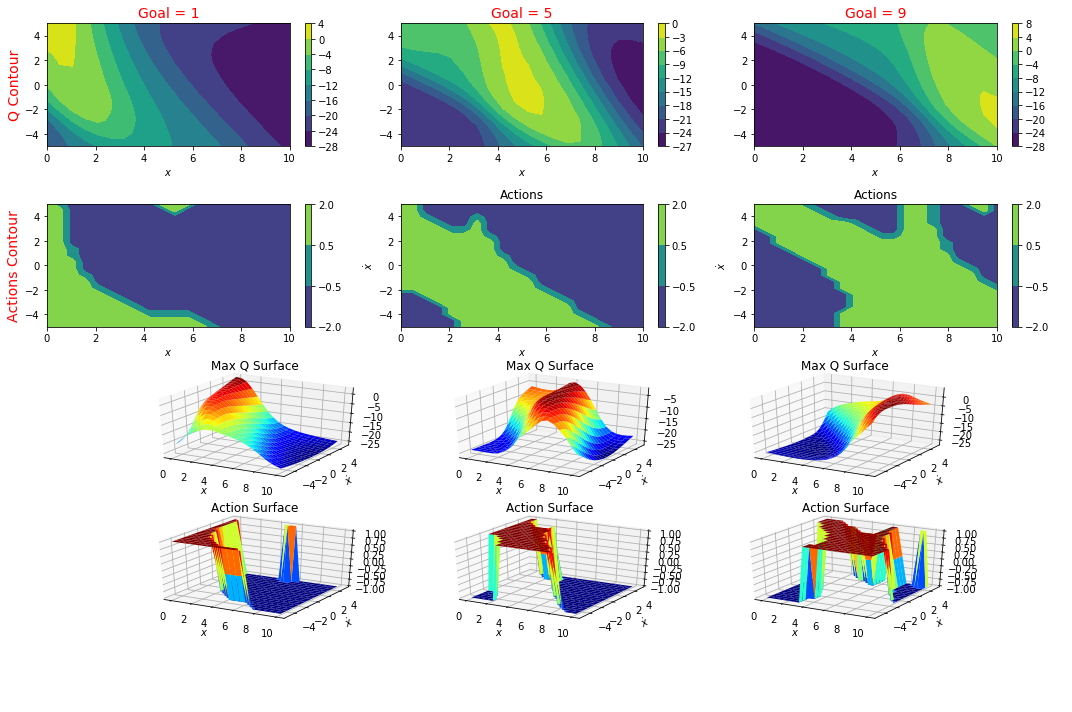

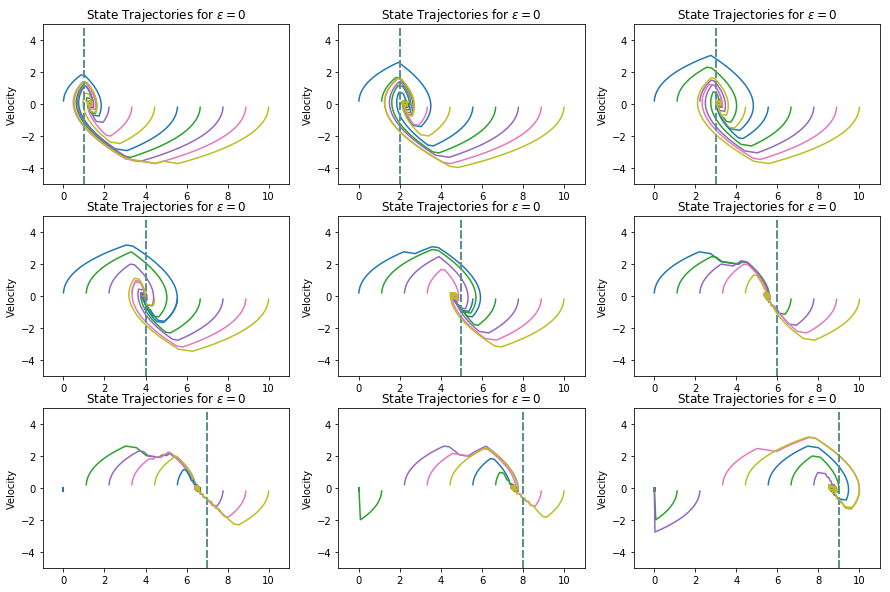

In [98]:
fig = plt.figure(figsize=(15,10))
plotContours(nnetQ)
fig = plt.figure(figsize=(15,10))
testAll(nnetQ, 10, 500)

**More trials, steps, SCGs, and smaller final epsilon**

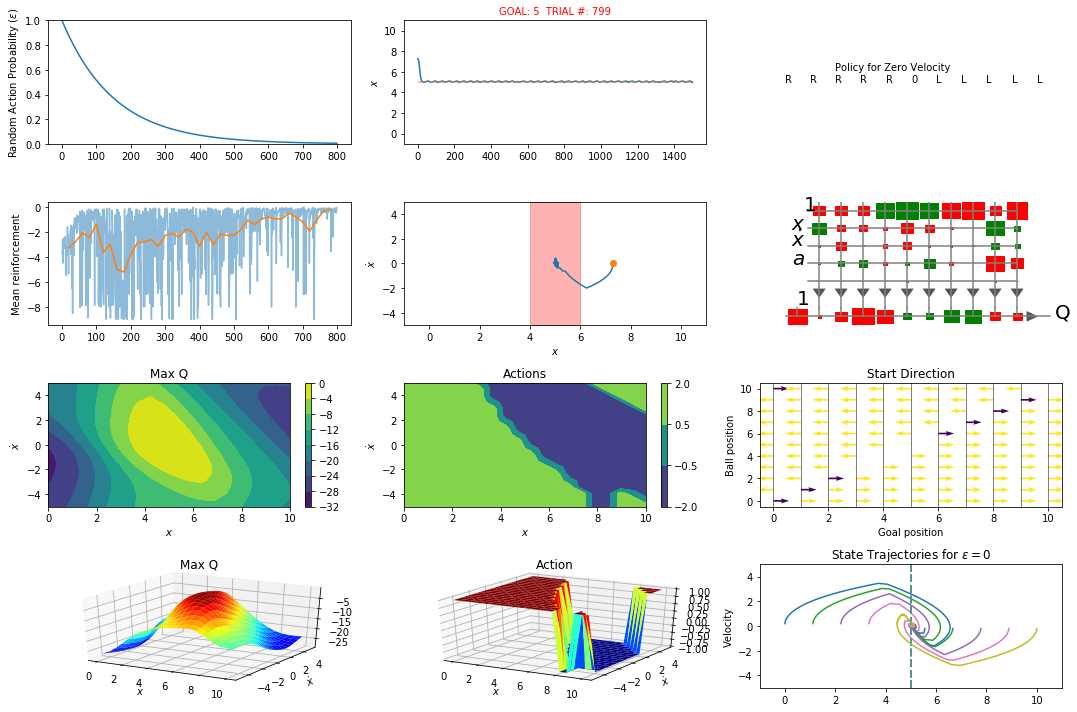

In [99]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(15,10))

gamma = 0.8        # discount factor
nTrials = 800         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1500 # number of steps between new random initial states
nSCGIterations = 8  # maximum number of SCG iterations
finalEpsilon = 0.005 # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon)/(nTrials)) # to produce this final value
print("epsilonDecay is",epsilonDecay)


nnetQ = nn.NeuralNetwork(4, 10, 1)  # ((0,10),(-4,4),(-1,1)))
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ,  initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    nnetQ.train(X, R + gamma*Qn, nIterations=nSCGIterations)
    goalPos = X[0,2]

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial+1 == nTrials or trial % (nTrials/40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace, goalPos)
        testIt(nnetQ, 10, 500, goalPos)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

These plots might look a little better but it is a bit too close to tell for sure.  I do like the Q Contour plots for the goals because I see peaks in the area where position = goal and velocity = 0.

/Users/zachgoodenow/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


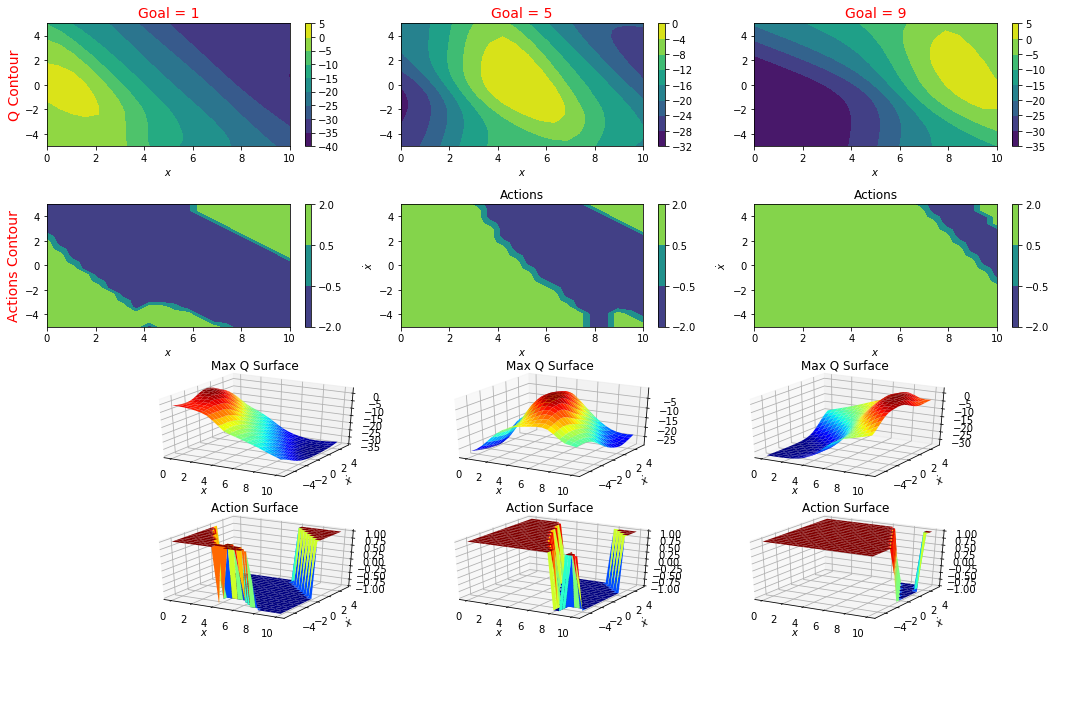

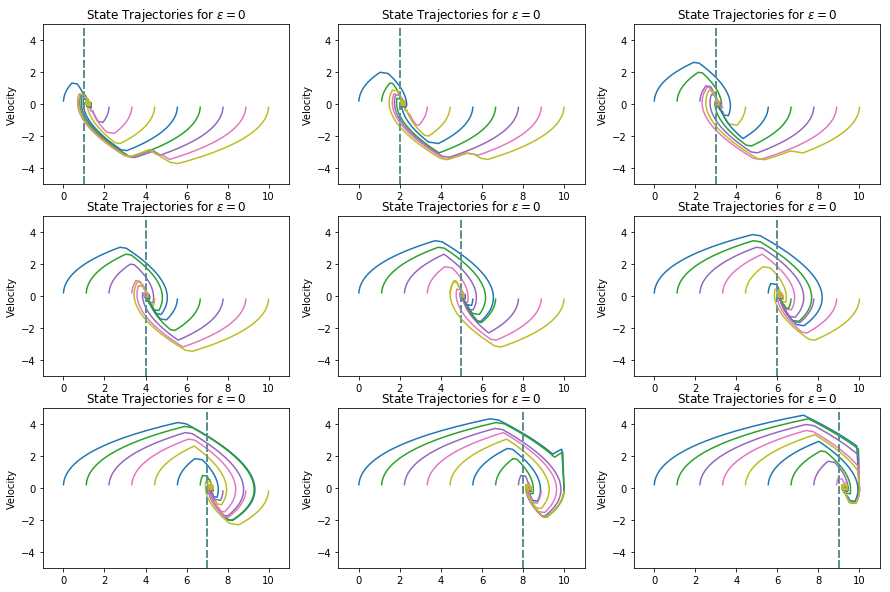

In [100]:
fig = plt.figure(figsize=(15,10))
plotContours(nnetQ)
fig = plt.figure(figsize=(15,10))
testAll(nnetQ, 10, 500)

## Best network found

<div class="alert alert-block alert-success">

My pick for the best network I could make had the following arguments:
- `gamma` = 0.9
- `nTrials` = 800         
- `nStepsPerTrial` = 1500 
- `nSCGIterations` = 8  
- `finalEpsilon` = 0.005 
- `Hidden layer structure` = Bottleneck - [10,8,6,4,2,4,6,8,10]

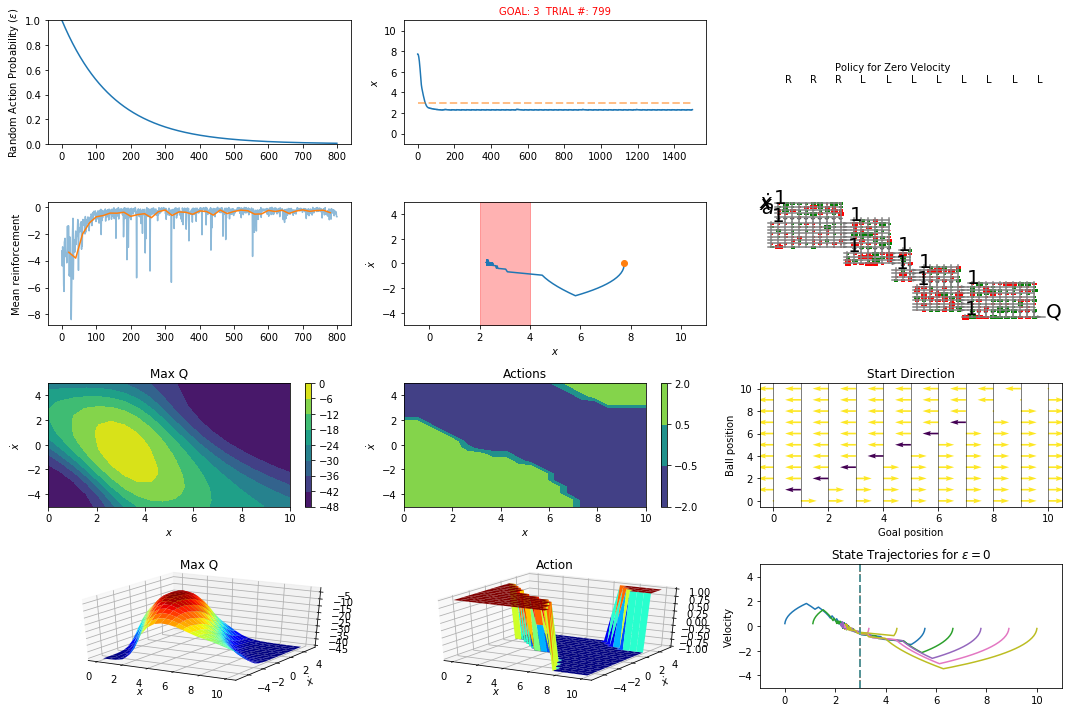

In [112]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(15,10))

gamma = 0.9        # discount factor
nTrials = 800         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1500 # number of steps between new random initial states
nSCGIterations = 8  # maximum number of SCG iterations
finalEpsilon = 0.005 # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon)/(nTrials)) # to produce this final value
print("epsilonDecay is",epsilonDecay)


nnetQ = nn.NeuralNetwork(4, [10,8,6,4,2,4,6,8,10], 1)  
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ,  initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    nnetQ.train(X, R + gamma*Qn, nIterations=nSCGIterations)
    goalPos = X[0,2]

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial+1 == nTrials or trial % (nTrials/40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace, goalPos)
        testIt(nnetQ, 10, 500, goalPos)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

/Users/zachgoodenow/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


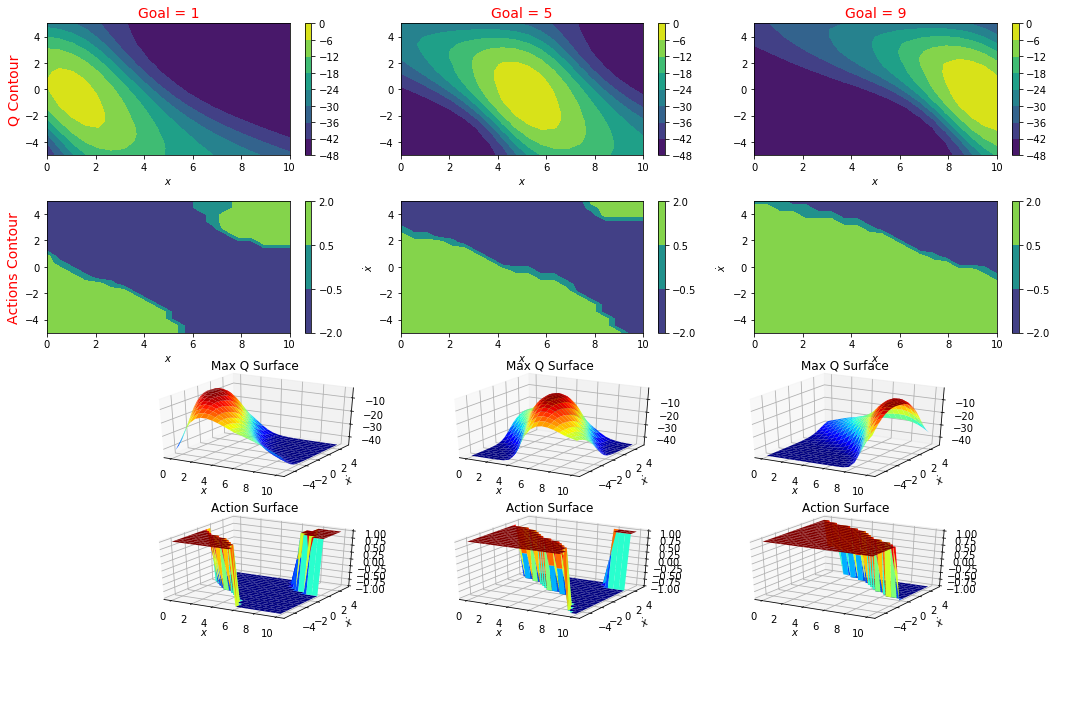

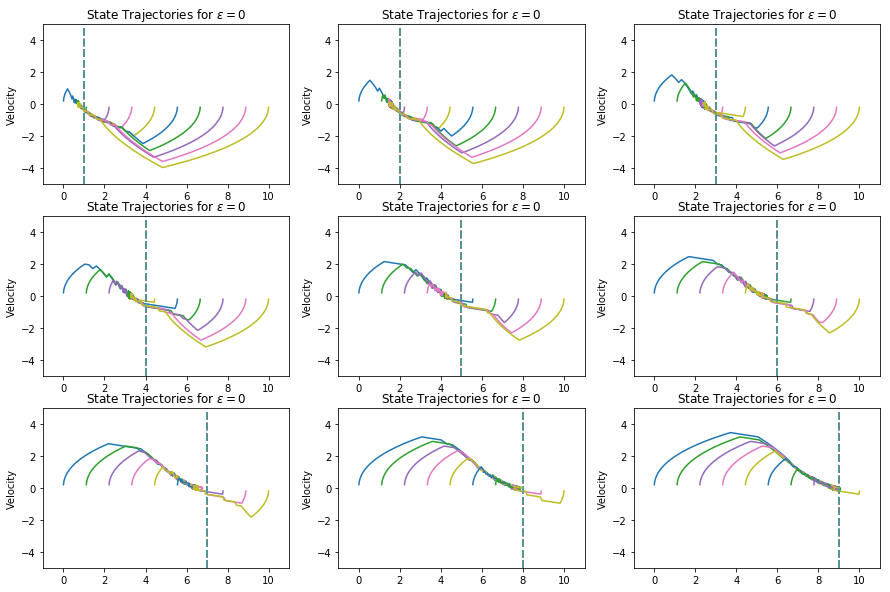

In [113]:
fig = plt.figure(figsize=(15,10))
plotContours(nnetQ)
fig = plt.figure(figsize=(15,10))
testAll(nnetQ, 10, 500)

This is another good network but I dont think it is as good as the one above judging by the plots.

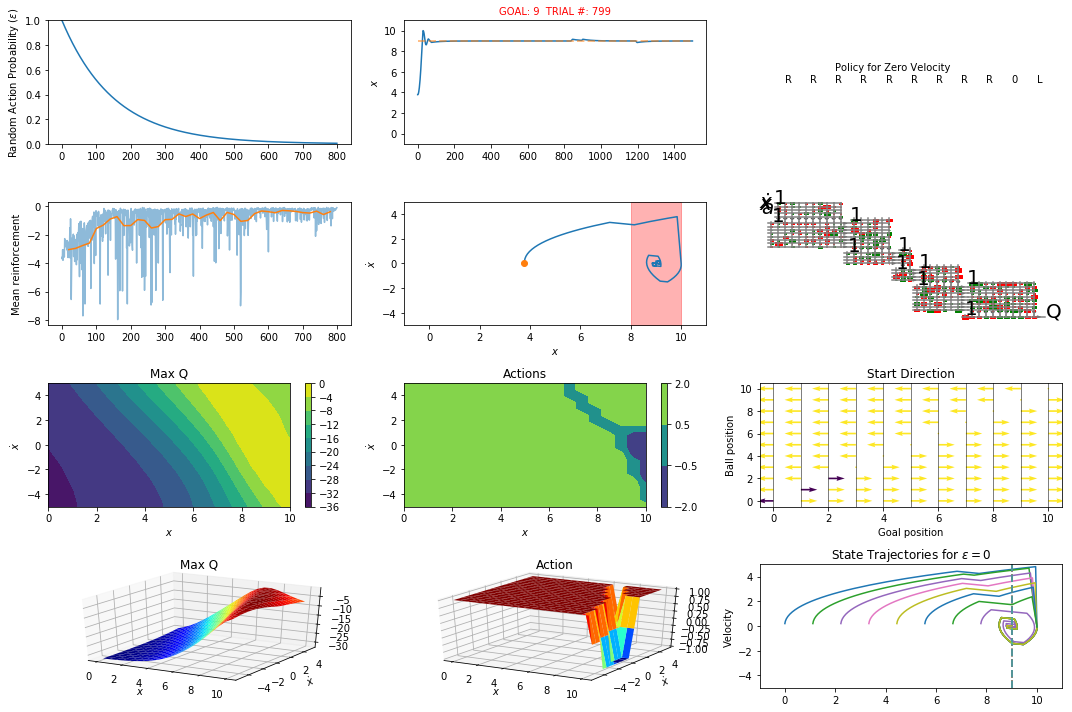

In [110]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(15,10))

gamma = 0.8        # discount factor
nTrials = 800         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1500 # number of steps between new random initial states
nSCGIterations = 8  # maximum number of SCG iterations
finalEpsilon = 0.005 # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon)/(nTrials)) # to produce this final value
print("epsilonDecay is",epsilonDecay)


nnetQ = nn.NeuralNetwork(4, [10,8,6,4,2,4,6,8,10], 1)  
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ,  initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    nnetQ.train(X, R + gamma*Qn, nIterations=nSCGIterations)
    goalPos = X[0,2]

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial+1 == nTrials or trial % (nTrials/40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace, goalPos)
        testIt(nnetQ, 10, 500, goalPos)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

/Users/zachgoodenow/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


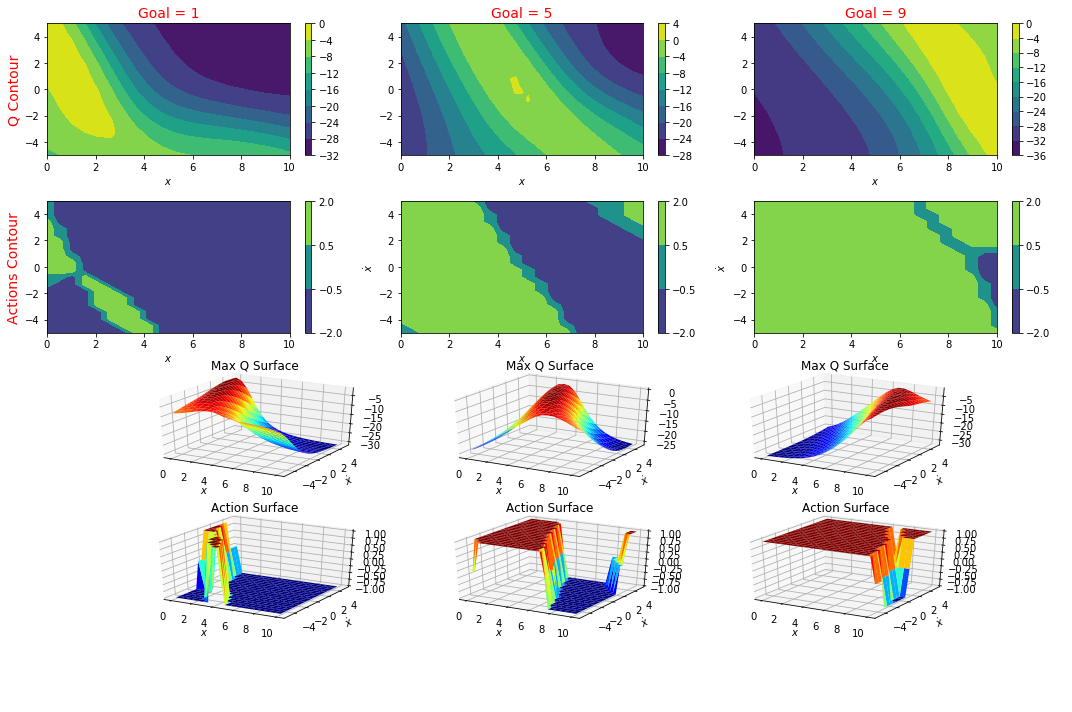

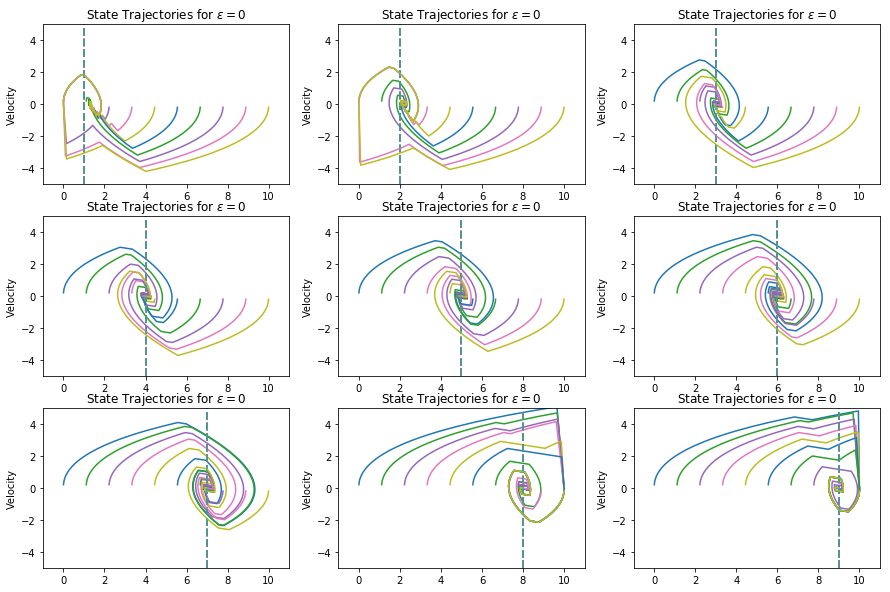

In [111]:
fig = plt.figure(figsize=(15,10))
plotContours(nnetQ)
fig = plt.figure(figsize=(15,10))
testAll(nnetQ, 10, 500)

***

***

### Experiment with values of the parameters

In this section I experiment with values of the parameters, such as the number of trials, number of steps per trial, number of SCG iterations in each train call, number of hidden units, finalEpsilon, and gamma.  To do this I made a function that creates a network using these parameters.  I found that plotting my arrow plot and the state trajectory trial plots were enough to evaluate the ability of the network.  I used the information I gained here to influence my choices from the plotting examples above.  I left these in here to show my attempts.

In [72]:
def runNet(gamma = 0.8, nTrials = 500, nStepsPerTrial = 1000, nSCGIterations = 4, finalEpsilon = 0.01, nh = 10):
    # make network
    nnetworkQ = nn.NeuralNetwork(4, nh, 1)  # ((0,10),(-4,4),(-1,1)))
    setupStandardization(nnetworkQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])
    
    # vars
    epsilonDecay =  np.exp(np.log(finalEpsilon)/(nTrials)) # to produce this final value
    
    
    epsilon = 1         # initial epsilon value
    print('gamma = {}, nTrials = {}, nStepsPerTrial = {}, nSCGIterations = {}, finalEpsilon = {}'.format(gamma,
                                                                                                        nTrials,
                                                                                                        nStepsPerTrial,
                                                                                                        nSCGIterations,
                                                                                                        finalEpsilon))
    print('trial:', end = ' ')
    for trial in range(nTrials):
        # Train the network
        X, R, Qn = makeSamples(nnetworkQ,  initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
        nnetworkQ.train(X, R + gamma*Qn, nIterations=nSCGIterations)
        
        # Update epsilon
        epsilon *= epsilonDecay
        
        if(trial % 50 == 0): print(trial, ',', end=" ")
    return nnetworkQ

**gamma = 0.8, nTrials = 500, nStepsPerTrial = 1000, nSCGIterations = 4, finalEpsilon = 0.01, nh = 10** <br>
This will be the base line for my comparisons.  This is a good base line because the network is doing decent but there is still room for improvement.

gamma = 0.8, nTrials = 500, nStepsPerTrial = 1000, nSCGIterations = 4, finalEpsilon = 0.01
trial: 0 , 50 , 100 , 150 , 200 , 250 , 300 , 350 , 400 , 450 , 

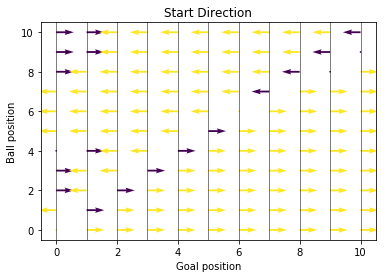

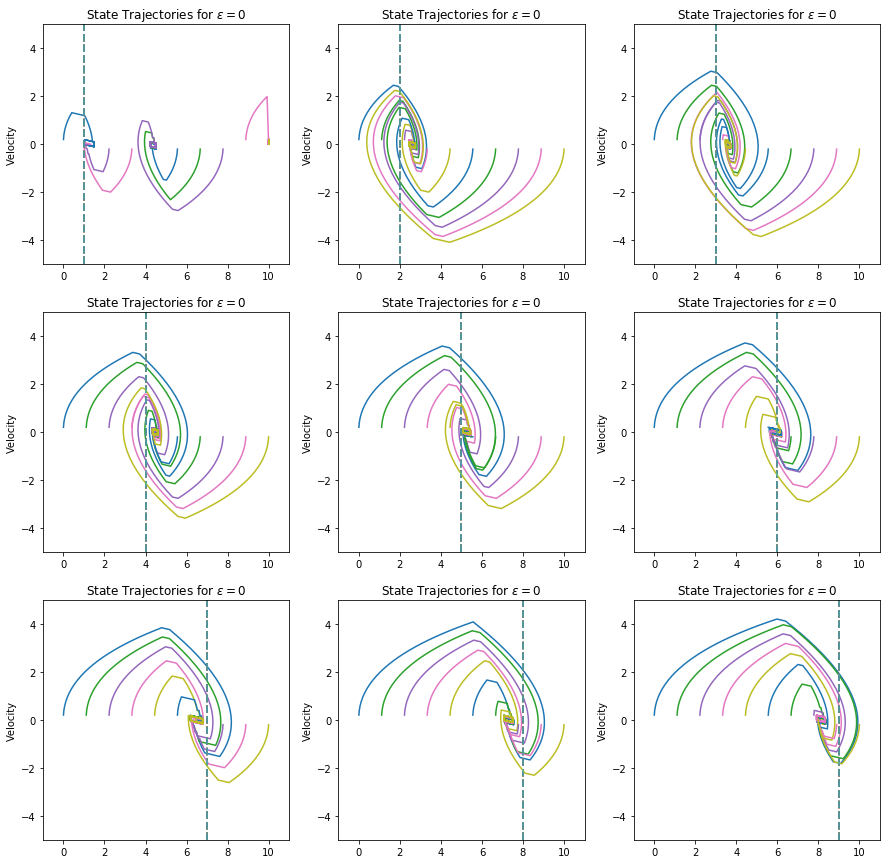

In [65]:
network = runNet()
testStarts(network)
fig = plt.figure(figsize=(15,15))
testAll(network, 10, 500)

**nTrials = 250, nStepsPerTrial = 500** <br>
With half as many trials and half as many steps per trial, the network preforms worse. 

gamma = 0.8, nTrials = 250, nStepsPerTrial = 500, nSCGIterations = 4, finalEpsilon = 0.01
trial: 0 , 50 , 100 , 150 , 200 , 

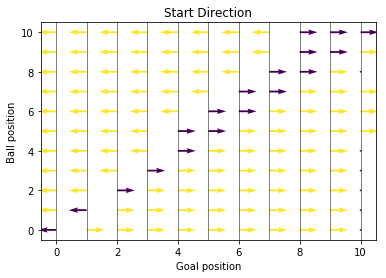

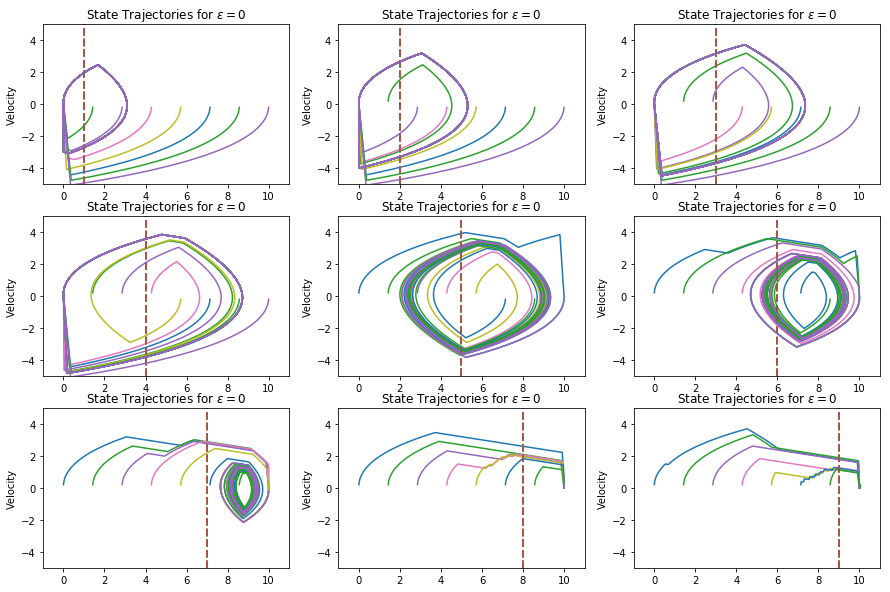

In [66]:
network2 = runNet(nTrials = 250, nStepsPerTrial = 500)
testStarts(network2)
fig = plt.figure(figsize=(15,10))
testAll(network2, 8, 250)

**nTrials = 250, nStepsPerTrial = 500, nSCGIterations = 8** <br>
With twice as many SCG iterations, the network looks like the network is preforming a bit better in the state trajectory plots but there are still trials where the goal is not reached.  In these trials, the ball gets stuck on one side. 

gamma = 0.8, nTrials = 250, nStepsPerTrial = 500, nSCGIterations = 8, finalEpsilon = 0.01
trial: 0 , 50 , 100 , 150 , 200 , 

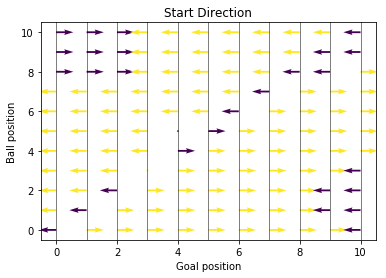

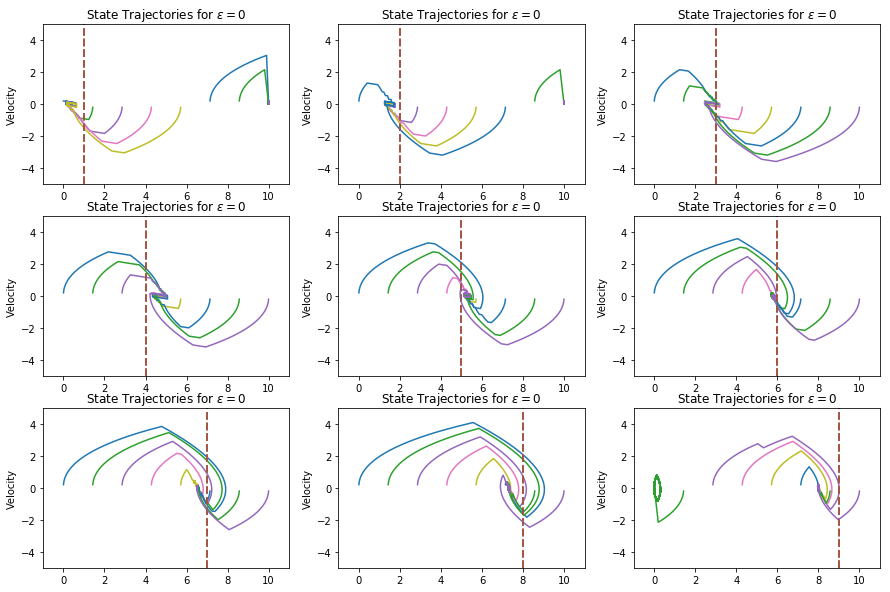

In [67]:
network3 = runNet(nTrials = 250, nStepsPerTrial = 500, nSCGIterations = 8)
testStarts(network3)
fig = plt.figure(figsize=(15,10))
testAll(network3, 8, 250)

**gamma = 0.6**<br>
Clearly a gamma value of 0.8 is better than one of 0.6 based off of these plots.  This could be because a smaller gamma value puts less weight on each Q value combined with the reinforcement value when the network is trained.

gamma = 0.6, nTrials = 500, nStepsPerTrial = 1000, nSCGIterations = 4, finalEpsilon = 0.01
trial: 0 , 50 , 100 , 150 , 200 , 250 , 300 , 350 , 400 , 450 , 

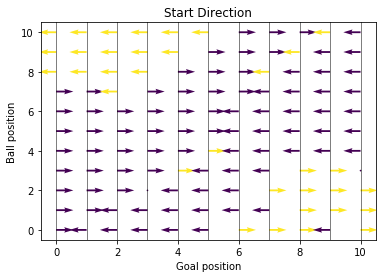

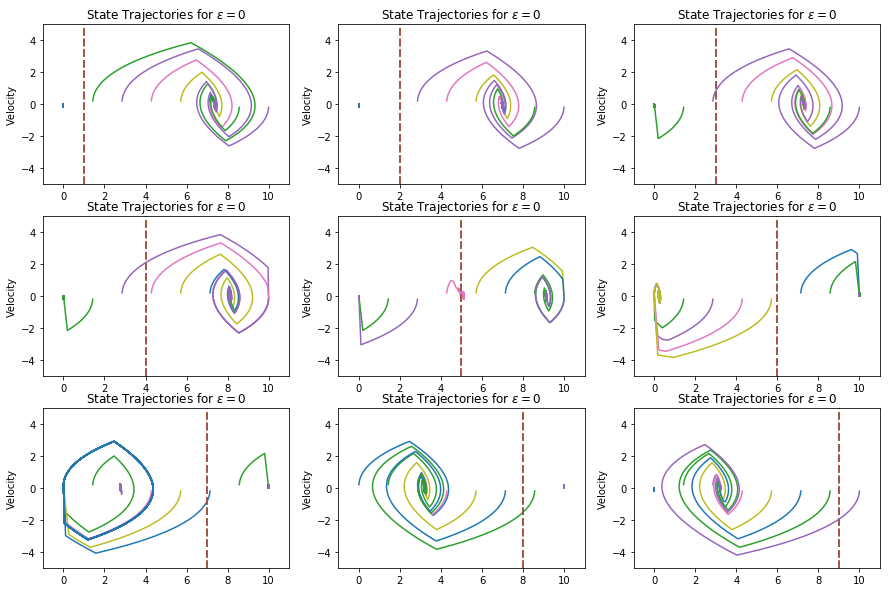

In [68]:
network4 = runNet(gamma = 0.6)
testStarts(network4)
fig = plt.figure(figsize=(15,10))
testAll(network4, 8, 500)

**nTrials = 800, nStepsPerTrial = 1500, nSCGIterations = 4, finalEpsilon = 0.005**<br>
With more trials, more steps per trial, and a smaller final epsilon value, the network looks like it is preforming quite well.  There are still a few incorrect starting actions in the Start Direction plot. However, the State Trajectory plots look like every trial reaches the goal.  These plots look very uniform which is good as far as consistency of the network. This looks like the best network that I have trained so far.

gamma = 0.8, nTrials = 800, nStepsPerTrial = 1500, nSCGIterations = 4, finalEpsilon = 0.005
trial: 0 , 50 , 100 , 150 , 200 , 250 , 300 , 350 , 400 , 450 , 500 , 550 , 600 , 650 , 700 , 750 , 

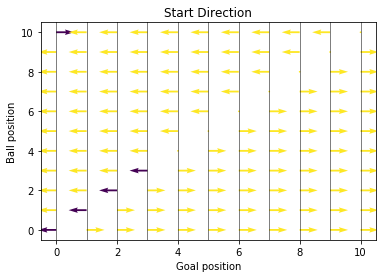

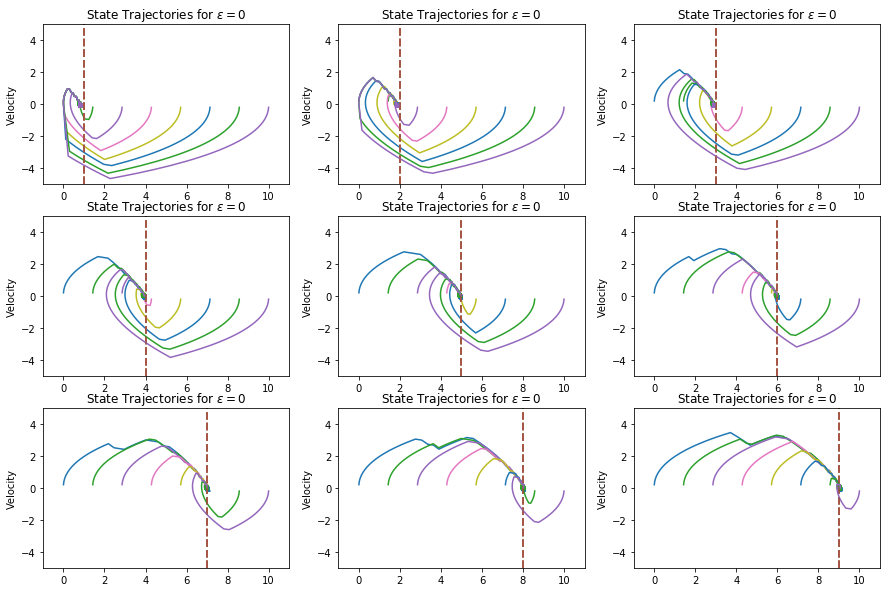

In [69]:
network5 = runNet(nTrials = 800, nStepsPerTrial = 1500, nSCGIterations = 4, finalEpsilon = 0.005)
testStarts(network5)
fig = plt.figure(figsize=(15,10))
testAll(network5, 8, 500)

**nTrials = 1500, nStepsPerTrial = 1000** <br>
Since more trials and steps per trial seam to make better networks, I tried this network with a large amount of trials and steps.  It actually didnt preform exponentially better than the base trial which is good to note.  However, this network might preform better with a smaller final epsilon value since the learning can be slower since there are more trials to learn from.

gamma = 0.8, nTrials = 1500, nStepsPerTrial = 1000, nSCGIterations = 4, finalEpsilon = 0.01
trial: 0 , 50 , 100 , 150 , 200 , 250 , 300 , 350 , 400 , 450 , 500 , 550 , 600 , 650 , 700 , 750 , 800 , 850 , 900 , 950 , 1000 , 1050 , 1100 , 1150 , 1200 , 1250 , 1300 , 1350 , 1400 , 1450 , 

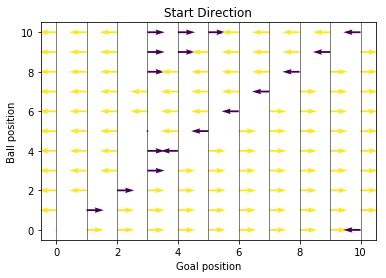

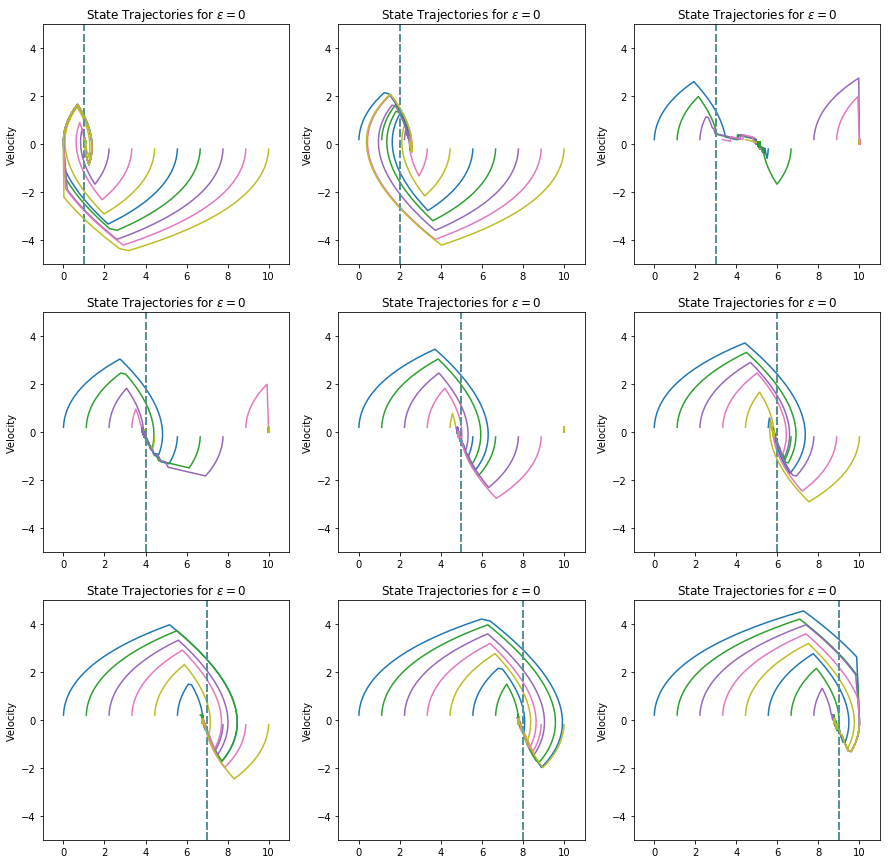

In [70]:
bignet = runNet(nTrials = 1500, nStepsPerTrial = 1000)
testStarts(bignet)
fig = plt.figure(figsize=(15,15))
testAll(bignet, 10, 500)

**Hidden unit layers: more vs. less**

Both of these networks are preforming decently well but not as good as when `nh = 10`.  I also try a bottle neck type hidden layer. 

gamma = 0.8, nTrials = 500, nStepsPerTrial = 1000, nSCGIterations = 4, finalEpsilon = 0.01
trial: 0 , 50 , 100 , 150 , 200 , 250 , 300 , 350 , 400 , 450 , 

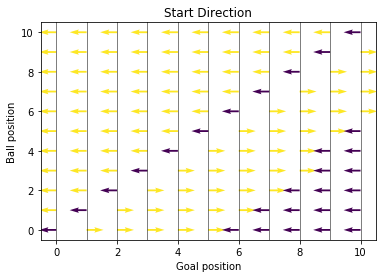

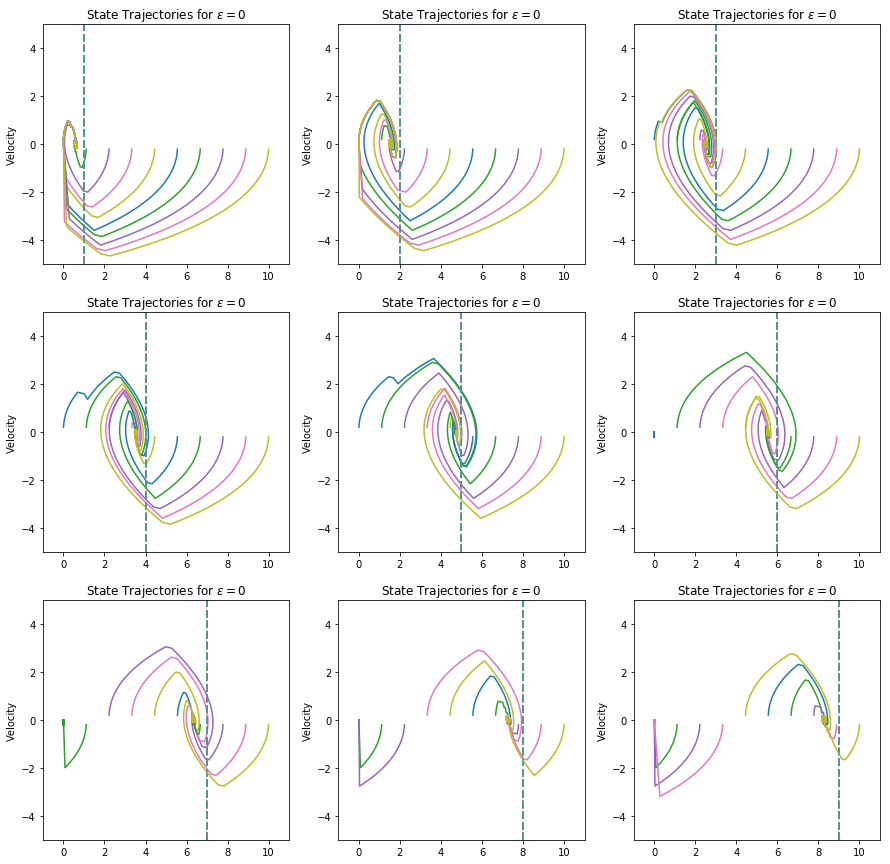

In [73]:
moreHidNet = runNet(nh = 15)
testStarts(moreHidNet)
fig = plt.figure(figsize=(15,15))
testAll(moreHidNet, 10, 500)

gamma = 0.8, nTrials = 500, nStepsPerTrial = 1000, nSCGIterations = 4, finalEpsilon = 0.01
trial: 0 , 50 , 100 , 150 , 200 , 250 , 300 , 350 , 400 , 450 , 

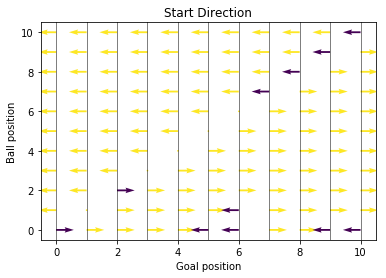

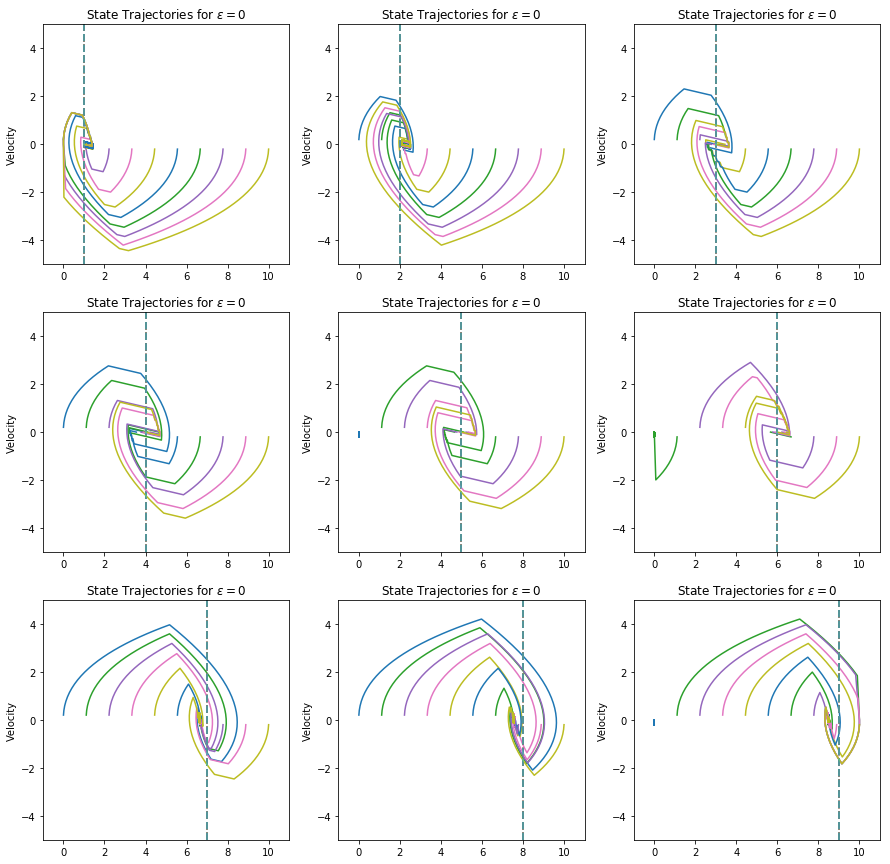

In [74]:
lessHidNet = runNet(nh = 5)
testStarts(lessHidNet)
fig = plt.figure(figsize=(15,15))
testAll(lessHidNet, 10, 500)

**Bottle neck hidden layer**<br>
This bottle neck network actually looks pretty good.  There are only 4 purple arrows and all the trials are landing on the goal at the end.  

gamma = 0.8, nTrials = 500, nStepsPerTrial = 1000, nSCGIterations = 4, finalEpsilon = 0.01
trial: 0 , 50 , 100 , 150 , 200 , 250 , 300 , 350 , 400 , 450 , 

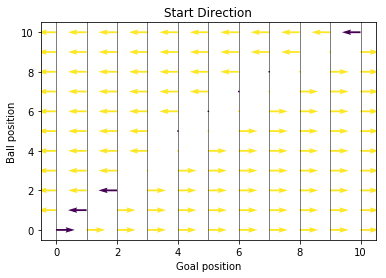

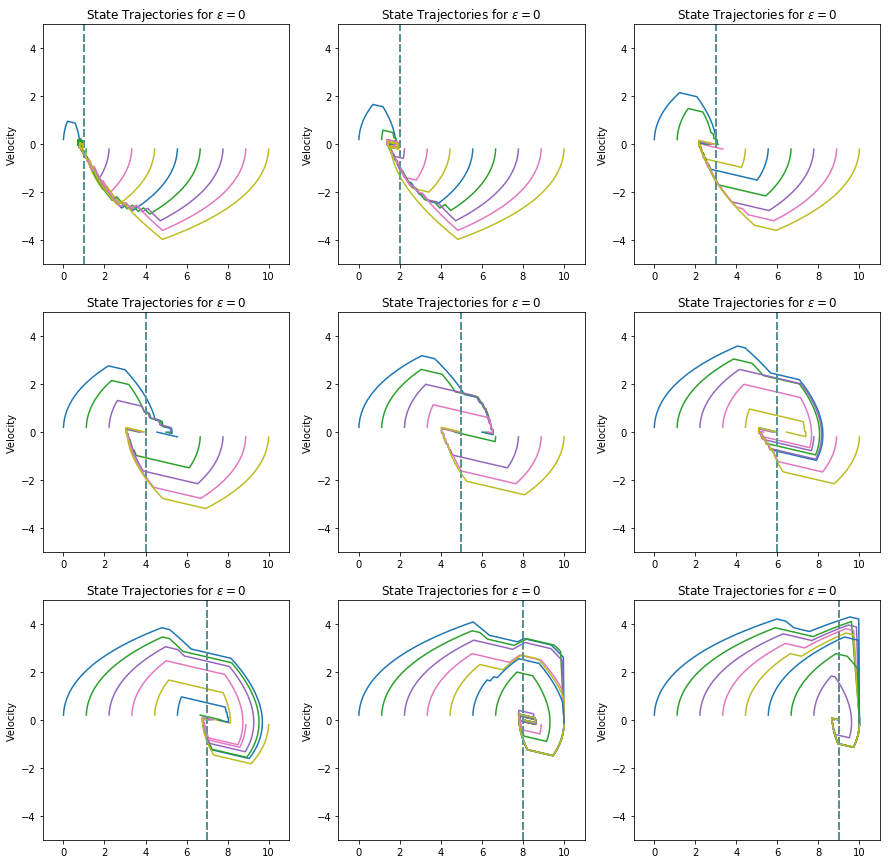

In [101]:
bottleNeckNet = runNet(nh = [10,8,6,4,2,4,6,8,10])
testStarts(bottleNeckNet)
fig = plt.figure(figsize=(15,15))
testAll(bottleNeckNet, 10, 500)